# Import packages

In [ ]:
!pip install  google-cloud-aiplatform
!pip install vertexai
!pip install google-auth

import pandas as pd
import numpy as np
import base64
import vertexai
import random
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt

from vertexai.generative_models import GenerativeModel, SafetySetting
from vertexai.preview.language_models import TextGenerationModel
from vertexai.preview.language_models import ChatModel, InputOutputTextPair
from google.colab import auth as google_auth
google_auth.authenticate_user()

# Collect user inputs (Python inputs)

# Step 1: Instructions for Uploading
To upload your CSV file:
1. Click on the folder icon on the left sidebar to open the file browser.
2. Click the upload icon (a file with an upward arrow) to select and upload your CSV file.
3. After the file is uploaded, note the file name and enter it in the prompt below.

In [ ]:
#JB

# Step 2: Prompt for the CSV file name
file_name = input("Please enter the name of your uploaded CSV file (e.g., 'your_file.csv'): ")

# Load the CSV file into a DataFrame
try:
    data = pd.read_csv(file_name)
    print("File loaded successfully!\n")
except FileNotFoundError:
    print("File not found. Please make sure you've uploaded the file and entered the correct name.")
    raise

# Display the DataFrame for user's reference
print("Here is a preview of the dataset:")
display(data.head())

# Step 3: Selecting demographic columns
# List of demographics to identify
demographics = {
    "Country": None,
    "Age": None,
    "Marital Status": None,
    "Employment Status": None,
    "Monthly Household Income": None
}

# Function to get user input for each characteristic
def get_user_column_choice(demographic):
    print(f"\nPlease select the column for *{demographic}* (or type 'skip' if not available):")
    columns = data.columns.tolist()
    for idx, col in enumerate(columns):
        print(f"{idx + 1}: {col}")
    while True:
        choice = input(f"Enter the number corresponding to '{demographic}': ")
        if choice.lower() == 'skip':
            return None
        elif choice.isdigit() and 1 <= int(choice) <= len(columns):
            return columns[int(choice) - 1]
        else:
            print("Invalid choice, please try again or type 'skip'.")

# Loop through each demographic and get user choices
for demographic in demographics.keys():
    selected_column = get_user_column_choice(demographic)
    demographics[demographic] = selected_column

# Summary confirmation
print("\nYou selected the following columns for each characteristic:")
for demographic, column in demographics.items():
    print(f"{demographic}: {column if column else 'Not provided'}")

# Confirm choices
confirm = input("Is this correct? (yes/no): ").strip().lower()
if confirm == 'no':
    print("You can re-run the cell to make changes.")
else:
    print("Selections confirmed.")

Please enter the name of your uploaded CSV file (e.g., 'your_file.csv'): wpp_merged_result_VT.csv
File loaded successfully!

Here is a preview of the dataset:


<ipython-input-30-558968820466>:8: DtypeWarning: Columns (3,17,18,19,24,25,26,27,29,30,32,33,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_name)


,record,uuid,A1,Q50r12oe,Qfeed1_subsr1,Qfeed1_subsr2,Qfeed1_subsr3,Qfeed1_subsr4,Qfeed1_subsr5,Qfeed2_subsr1,...,F5r3,F5r4,F5r5,F5r6,F5r7,F5r8,F5r9,F5r10,F5r11,rec_y
0,4741,1vputuurrypknm8p,4,NaN,Above Average,Average,High,Very High,Above Average,Promotion,...,0,0,0,1,1,1,0,0,0,003c1944-76c6-0fd6-6723-2d17fea31ea0
1,3469,pxv0rgyz0768rp1y,4,NaN,Very High,Average,Very High,Very High,Very High,Prevention,...,0,0,0,0,1,0,0,0,0,004341e9-1a79-5fb0-9289-7568e55b170f
2,2802,yrhc0yg4p9wfwtea,4,NaN,High,Low,Average,Average,Average,Balanced,...,0,0,0,1,0,0,0,1,0,004e8d97-4069-ba26-96f7-b965f959a37d
3,4036,rdjh1rcdxvr0js2s,4,NaN,Above Average,Above Average,High,Above Average,Average,Promotion,...,0,0,0,0,1,1,0,0,0,0080e13d-9d49-d561-585d-d5abee6118cf
4,3042,yepsd2mmpnj831pk,4,NaN,Below Average,Very low,Very High,Average,Below Average,Balanced,...,0,0,0,1,0,1,0,0,0,00c2e245-c83e-d1d9-1a25-d6e9ee7223a1


Streaming output truncated to the last 5000 lines.
644: traitsSumr33
645: traitsSumr34
646: traitsSumr35
647: traitsSumr36
648: traitsSumr37
649: traitsSumr38
650: traitsSumr39
651: traitsSumr40
652: traitsSumr41
653: traitsSumr42
654: traitsSumr43
655: traitsSumr44
656: traitsSumr45
657: traitsSumr46
658: traitsSumr47
659: traitsSumr48
660: traitsSumr49
661: traitsSumr50
662: traitsSumr51
663: traitsSumr52
664: traitsSumr53
665: traitsSumr54
666: traitsSumr55
667: traitsSumr56
668: traitsSumr57
669: traitsSumr58
670: traitsSumr59
671: traitsSumr60
672: traitsSumr61
673: traitsSumr62
674: traitsSumr63
675: traitsSumr64
676: traitsSumr65
677: traitsSumr66
678: traitsSumr67
679: traitsSumr68
680: traitsSumr69
681: traitsSumr70
682: traitsSumr71
683: traitsSumr72
684: traitsSumr73
685: traitsSumr74
686: traitsSumr75
687: traitsSumr76
688: traitsSumr77
689: traitsSumr78
690: traitsSumr79
691: traitsSumr80
692: traitsSumr81
693: traitsSumr82
694: traitsMinr1
695: traitsMinr2
696: traitsMinr

In [ ]:
# Step 4: Selecting OCEAN columns
use_ocean = input("\nSpecify OCEAN traits for your virtual participants? [Y,N]: ").strip().upper()

if use_ocean == "Y":
    ocean_traits = {
        "Openness": None,
        "Conscientiousness": None,
        "Extraversion": None,
        "Agreeableness": None,
        "Neuroticism": None
    }

    print("\nSelecting OCEAN traits columns:")
    for trait in ocean_traits.keys():
        selected_column = get_user_column_choice(trait)
        ocean_traits[trait] = selected_column

    # Summary confirmation for OCEAN traits
    print("\nYou selected the following columns for each OCEAN trait:")
    for trait, column in ocean_traits.items():
        print(f"{trait}: {column if column else 'Not provided'}")

    # Confirm OCEAN choices
    confirm_ocean = input("Is this correct for OCEAN traits? (yes/no): ").strip().lower()
    if confirm_ocean == 'no':
        print("You can re-run the cell to make changes.")
    else:
        print("OCEAN trait selections confirmed.")

else:
    print("Skipping OCEAN traits selection.")

# Step 3 – worldview
# Step 4 – social styles

Streaming output truncated to the last 5000 lines.
642: traitsSumr31
643: traitsSumr32
644: traitsSumr33
645: traitsSumr34
646: traitsSumr35
647: traitsSumr36
648: traitsSumr37
649: traitsSumr38
650: traitsSumr39
651: traitsSumr40
652: traitsSumr41
653: traitsSumr42
654: traitsSumr43
655: traitsSumr44
656: traitsSumr45
657: traitsSumr46
658: traitsSumr47
659: traitsSumr48
660: traitsSumr49
661: traitsSumr50
662: traitsSumr51
663: traitsSumr52
664: traitsSumr53
665: traitsSumr54
666: traitsSumr55
667: traitsSumr56
668: traitsSumr57
669: traitsSumr58
670: traitsSumr59
671: traitsSumr60
672: traitsSumr61
673: traitsSumr62
674: traitsSumr63
675: traitsSumr64
676: traitsSumr65
677: traitsSumr66
678: traitsSumr67
679: traitsSumr68
680: traitsSumr69
681: traitsSumr70
682: traitsSumr71
683: traitsSumr72
684: traitsSumr73
685: traitsSumr74
686: traitsSumr75
687: traitsSumr76
688: traitsSumr77
689: traitsSumr78
690: traitsSumr79
691: traitsSumr80
692: traitsSumr81
693: traitsSumr82
694: traitsMi

In [ ]:

# Step 5 – capture required sample size
while True:
    try:
        sample_size = input("How big of a sample of this population do you need? (Enter a number 1-1000): ")
        sample_size = int(sample_size)
        if 1 <= sample_size <= 1000:
            print("Success!")
            break
        else:
            print("Invalid input. Please enter a number between 1 and 1000.")
    except ValueError:
        print("Invalid input. Please enter a valid integer between 1 and 1000.")

How big of a sample of this population do you need? (Enter a number 1-1000): 5
Success!


# Determine concentration of demographic + psychographic traits in population

In [ ]:
#SC

# Function to calculate and display proportions for mapped demographic columns
def calculate_proportion(data, column_mapping, category_name):
    proportions = {}
    print(f"\n{category_name} Data Concentration:")

    for demographic, column in column_mapping.items():
        if column not in data.columns:
            print(f"Warning: Column '{column}' (for '{demographic}') not found in data. Skipping.")
            continue
        print(f"\n{demographic} ({column}):")  # Display both demographic and actual column name
        # Calculate percentage
        demographic_proportions = data[column].value_counts(normalize=True)
        proportions[demographic] = demographic_proportions.to_dict()

        # Display each label's percentage
        for label, percentage in demographic_proportions.items():
            print(f"{label}: {percentage:.2%}")

    return proportions

# Using the demographics dictionary already created with user-defined mappings

calculate_proportion(data, demographics, "Demographic")

calculate_proportion(data, ocean_traits, "Psychographic")


Demographic Data Concentration:

Country (A1):
4: 100.00%

Age (HidA3):
2: 37.82%
3: 37.44%
4: 24.74%

Marital Status (A4):
3: 53.18%
1: 39.15%
2: 5.88%
4: 1.61%
5: 0.19%

Employment Status (A5):
1: 65.97%
2: 13.36%
6: 12.23%
3: 5.40%
5: 1.71%
4: 1.04%
7: 0.28%

Monthly Household Income (A6):
20: 34.98%
21: 26.07%
19: 22.75%
18: 14.69%
22: 1.52%

Psychographic Data Concentration:

Openness (Qfeed1_subsr1):
Very High: 43.22%
Average: 17.73%
Above Average: 11.00%
High: 11.00%
Below Average: 8.15%
Low: 4.45%
Very low: 4.45%

Conscientiousness (Qfeed1_subsr2):
Average: 27.01%
Very High: 20.38%
Very low: 16.02%
Low: 10.14%
Above Average: 9.86%
Below Average: 9.38%
High: 7.20%

Extraversion (Qfeed1_subsr3):
Very High: 27.30%
Average: 24.17%
Above Average: 15.73%
High: 12.51%
Below Average: 8.91%
Low: 6.07%
Very low: 5.31%

Agreeableness (Qfeed1_subsr4):
Very High: 39.05%
Average: 21.99%
Above Average: 13.27%
High: 12.89%
Below Average: 6.35%
Low: 4.17%
Very low: 2.27%

Neuroticism (Qfeed1_s

{'Openness': {'Very High': 0.4322274881516588,
  'Average': 0.17725118483412322,
  'Above Average': 0.10995260663507109,
  'High': 0.10995260663507109,
  'Below Average': 0.08151658767772511,
  'Low': 0.04454976303317536,
  'Very low': 0.04454976303317536},
 'Conscientiousness': {'Average': 0.27014218009478674,
  'Very High': 0.2037914691943128,
  'Very low': 0.16018957345971563,
  'Low': 0.1014218009478673,
  'Above Average': 0.0985781990521327,
  'Below Average': 0.0938388625592417,
  'High': 0.07203791469194312},
 'Extraversion': {'Very High': 0.2729857819905213,
  'Average': 0.24170616113744076,
  'Above Average': 0.15734597156398103,
  'High': 0.12511848341232226,
  'Below Average': 0.08909952606635071,
  'Low': 0.06066350710900474,
  'Very low': 0.05308056872037915},
 'Agreeableness': {'Very High': 0.390521327014218,
  'Average': 0.21990521327014217,
  'Above Average': 0.13270142180094788,
  'High': 0.12890995260663507,
  'Below Average': 0.06350710900473934,
  'Low': 0.041706161

TO-DO: Applying these proportions to the silicon sample

# Generate prompt (Python strings)

In [ ]:
#PJ
#TODO: Need to refine methods for generating sample
# Function to generate natural-language prompt based on demographic and OCEAN traits



#Generates prompt based on persona, to be called multiple times based on sample size
def generate_prompt(persona):
    prompt = (
        f"Racially, you are coded as {persona.get('Country', 'of unspecified race')}. The coding maps to the following races: 1 is \'Indonesia\', 2 is \'Phillipines\', 3 is \'Thailand\', and 4 is \'Vietnam\'."
        #f"In terms of gender/sex, you are a {persona.get('Gender/Sex', 'of unspecified gender/sex')}. The coding maps to the following genders/sexes: 1 is \'Male\' and 2 is \'Female\'."
        f"Your age group is {persona.get('Age', 'unspecified')}. The coding maps to the following ages: 1 is \'17 years old and below\', 2 is \'18-25 years old (Gen Z)\', 3 is \'26-41 years old (Millenials)\', 4 is \'42-55 years old (Gen X)\', and 5 is \'56 years old and up\'."
        f"Your marital status code is {persona.get('Marital Status', 'unspecified')}. The coding maps to the following marital status: 1 is \'Single\', 2 is \'Married without kids\', 3 is \'Married with kids\', 4 is \'Divorced/Separated\', and 5 is \'Prefer not to answer\'."
        f"You currently are coded as {persona.get('Employment Status', 'unemployed')}. The coding maps to the following employment status: 1 is \'Working full-time\', 2 is \'Working part-time\', 3 is \'Self-employed, running own business\', 4 is \'Full-time homemaker\', 5 is \'Unemployed, in between jobs\', 6 is \'Student\', and 7 is \'Retired\'."
        f"Your household income group is {persona.get('Monthly Household Income', 'unspecified')} per month. The coding maps to the following income group: 18 is \'10,000,000 dong and below\', 19 is \'10,000,001 - 17,000,000 dong\', 20 is \'17,000,001 - 26,000,000 dong\', 21 is \'26,000,001 and above\', and 22 is \'Prefer not to answer\'."
    )

    if persona.get('Openness'):
        prompt += f"Your Openness score is {persona['Openness']}. "
    if persona.get('Conscientiousness'):
        prompt += f"Your Conscientiousness score is {persona['Conscientiousness']}. "
    if persona.get('Extraversion'):
        prompt += f"Your Extraversion score is {persona['Extraversion']}. "
    if persona.get('Agreeableness'):
        prompt += f"Your Agreeableness score is {persona['Agreeableness']}. "
    if persona.get('Neuroticism'):
        prompt += f"Your Neuroticism score is {persona['Neuroticism']}. "

    return prompt.strip()

#Generates personas using proportions of each demographic and trait as both prompts to feed into the model and a dataframe to reference at the end
def create_sample_personas(data, sample_size, demographics, ocean_traits):
    # Generate sample personas
    sampled_personas = []
    prompts = []

    # Calculate probabilities for demographic and OCEAN traits
    demographic_proportions = calculate_proportion(data, demographics, "Demographic")
    ocean_proportions = calculate_proportion(data, ocean_traits, "Psychographic")

    for _ in range(sample_size):
        persona = {}

        # Generate demographic traits based on calculated proportions
        for demographic in demographics:
            if demographic in demographic_proportions:
                values = list(demographic_proportions[demographic].keys())
                probabilities = list(demographic_proportions[demographic].values())
                selected_value = np.random.choice(values, p=probabilities)
                persona[demographic] = selected_value

        # Generate OCEAN traits based on calculated proportions
        for trait in ocean_traits:
            if trait in ocean_proportions:
                values = list(ocean_proportions[trait].keys())
                probabilities = list(ocean_proportions[trait].values())
                selected_value = np.random.choice(values, p=probabilities)
                persona[trait] = selected_value

        # Generate prompt for the persona
        prompt_text = generate_prompt(persona)
        prompts.append(prompt_text)

        # Append persona data as a row to the list
        sampled_personas.append(persona)

    # Create DataFrame for personas
    personas_df = pd.DataFrame(sampled_personas)

    return personas_df, prompts

# Generate sample personas and prompts
personas_df, prompts = create_sample_personas(data, sample_size, demographics, ocean_traits)




Demographic Data Concentration:

Country (A1):
4: 100.00%

Age (HidA3):
2: 37.82%
3: 37.44%
4: 24.74%

Marital Status (A4):
3: 53.18%
1: 39.15%
2: 5.88%
4: 1.61%
5: 0.19%

Employment Status (A5):
1: 65.97%
2: 13.36%
6: 12.23%
3: 5.40%
5: 1.71%
4: 1.04%
7: 0.28%

Monthly Household Income (A6):
20: 34.98%
21: 26.07%
19: 22.75%
18: 14.69%
22: 1.52%

Psychographic Data Concentration:

Openness (Qfeed1_subsr1):
Very High: 43.22%
Average: 17.73%
Above Average: 11.00%
High: 11.00%
Below Average: 8.15%
Low: 4.45%
Very low: 4.45%

Conscientiousness (Qfeed1_subsr2):
Average: 27.01%
Very High: 20.38%
Very low: 16.02%
Low: 10.14%
Above Average: 9.86%
Below Average: 9.38%
High: 7.20%

Extraversion (Qfeed1_subsr3):
Very High: 27.30%
Average: 24.17%
Above Average: 15.73%
High: 12.51%
Below Average: 8.91%
Low: 6.07%
Very low: 5.31%

Agreeableness (Qfeed1_subsr4):
Very High: 39.05%
Average: 21.99%
Above Average: 13.27%
High: 12.89%
Below Average: 6.35%
Low: 4.17%
Very low: 2.27%

Neuroticism (Qfeed1_s

# Call Gemini API and create virtual participants (Gemini API)

In [ ]:
#Optimize system prompt
raw_prompt = """#system prompt/context
I want you to pretend to be a participant in my focus group.
I can\'t give you a complete description of the participant, so if you struggle to respond to a question feel free to make something up.
If you make up a response, you should try to make that response as realistic as possible given the description of your participant.
Your participant description is as follows: Unless stated otherwise everything about your life is average."""

In [ ]:
#JB
# Define function to call Vertex AI

model_name = "gemini-1.5-flash-002"
# Set up vertex AI for generation
def generate(prompts, questions):
    vertexai.init(project="wpp-ogilvy-05ca", location="us-central1")
    model = GenerativeModel(
        model_name,
        system_instruction=system_prompt,
        safety_settings=safety_settings
    )
    # List to hold responses
    all_responses = []

    # Loop through each prompt and question
    for prompt in prompts:
        persona_responses = []
        for question in questions:
            # Combine persona description (prompt) with the current question
            input_text = f"{prompt}\n\n{question}"

            # Generate response using the Vertex AI model
            response = model.generate_content(
                [input_text],  # Send the concatenated input
                generation_config=generation_config,
                stream=True
            )

            # Collect response text
            response_text = "".join([res.text.strip() for res in response])
            persona_responses.append(response_text)

        # Append responses for all questions for this persona
        all_responses.append(persona_responses)

    # Return a nested list where each element corresponds to a persona's responses to all questions
    return all_responses
    print(response.text, end="")


# Define single consistent system prompt and participant questions
system_prompt = """#context
For this exercise, you will be roleplaying as a participant in a focus group for market research.
I will provide you with a persona that describes the participant's demographics, lifestyle, and Big 5 personality traits.
You should embody this persona and answer questions as you think they would, providing realistic and detailed responses.
Don't be afraid to elaborate or share negative opinions - honesty is key! Here is your persona for this session:"""


questions = ["""#question
      I accomplish the goals I set for myself. How true is this statement for you personally? Answer with a number 1-4 ONLY, with the following key:
      1 = Not true, 2 = Partly true, 3 = Close to the truth, 4 = Absolutely true.
      """,

    """#question
       I attribute triumphs in my life to my skills and intelligence rather than to chance. How true is this statement for you personally? Answer with a number 1-4 ONLY, with the following key:
      1 = Not true, 2 = Partly true, 3 = Close to the truth, 4 = Absolutely true.
      """]


# Loop through list of identities generated, calling API once per virtual participant TODO

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
}


safety_settings = [
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
]


#TO DO - append responses to list for researcher review


# Write answers to CSV + display sample (Pandas)

In [ ]:
#PJ
# TO DO append model, max_output_tokens, temperature, etc DONE


def prepare_data_for_csv(responses, questions, personas_df):
    # Flatten the nested list of responses into a DataFrame-friendly format
    flattened_data = []
    for persona_idx, persona_responses in enumerate(responses):
        for question_idx, response in enumerate(persona_responses):
            # Combine persona data with question and response
            row_data = {
                "Question": questions[question_idx],
                "Response": response,
            }
            # Add persona details (e.g., demographics and OCEAN scores)
            for col in personas_df.columns:
                row_data[col] = personas_df.iloc[persona_idx][col]
            flattened_data.append(row_data)

    responses_df = pd.DataFrame(flattened_data)

    # Append model configuration information to the DataFrame
    responses_df["Model Name"] = model_name
    responses_df["Max Output Tokens"] = generation_config["max_output_tokens"]
    responses_df["Temperature"] = generation_config["temperature"]
    responses_df["Top P"] = generation_config["top_p"]

    # Print the DataFrame to check the output
    print("\nResponses:")
    print(responses_df.head())

    return responses_df


# Function to store generated responses in a file
def store_responses(full_responses_df):
    while True:
        # Prompt user to specify a file name for the output CSV
        output_file = input("Please enter a name for the output CSV file (e.g., 'responses.csv'): ").strip()

        # Check for invalid characters in the file name (e.g., "/, \, :, *, ?, ", <, >, |")
        if not re.match(r'^[\w\-. ]+$', output_file):
            print("Invalid file name. Please avoid special characters like / \\ : * ? \" < > |")
            continue

        # Ensure the file name ends with '.csv'
        if not output_file.endswith('.csv'):
            output_file += '.csv'

        # Attempt to save the DataFrame to a CSV file
        try:
            full_responses_df.to_csv(output_file, index=False)
            print(f"Responses saved successfully to {output_file}")
            break  # Exit loop if save is successful
        except Exception as e:
            print(f"An error occurred while saving responses: {e}. Please try again.")

# Generate responses and store them
responses = generate(prompts, questions)
full_responses_df = prepare_data_for_csv(responses, questions, personas_df)
store_responses(full_responses_df)



Responses:
                                            Question Response  Country  Age  \
0  #question\n      I accomplish the goals I set ...        2        4    3   
1  #question\n       attribute triumphs in my lif...        3        4    3   
2  #question\n      I accomplish the goals I set ...        2        4    2   
3  #question\n       attribute triumphs in my lif...        2        4    2   
4  #question\n      I accomplish the goals I set ...        3        4    3   

   Marital Status  Employment Status  Monthly Household Income   Openness  \
0               3                  3                        20  Very High   
1               3                  3                        20  Very High   
2               3                  1                        21    Average   
3               3                  1                        21    Average   
4               1                  1                        20    Average   

  Conscientiousness Extraversion  Agreeableness   



```
`# This is formatted as code`
```

#Check accuracy of predictions

In [ ]:
columns = data.columns.tolist()  # Get all column names from the dataset

# The user to input columns one by one
print("Available columns:")
for i, col in enumerate(columns):
    print(f"{i + 1}. {col}")

question_columns = []
print("\nEnter the column names one by one. Type 'stop' to finish.\n")

while True:
    user_input = input("Enter column name (or 'stop' to finish): ").strip()
    if user_input.lower() == "stop":
        break
    elif user_input in columns:
        question_columns.append(user_input)
        print(f"Added: {user_input}")
    else:
        print("Invalid column name. Please enter a valid column name from the list.")

print("\nSelected question columns:")
print(question_columns)



Available columns:
1. record
2. uuid
3. A1
4. Q50r12oe
5. Qfeed1_subsr1
6. Qfeed1_subsr2
7. Qfeed1_subsr3
8. Qfeed1_subsr4
9. Qfeed1_subsr5
10. Qfeed2_subsr1
11. Qfeed2_subsr2
12. Qfeed2_subsr3
13. Qfeed2_subsr4
14. Qfeed2_subsr5
15. Qfeed2_subsr6
16. Qfeed3_subsr1
17. Qfeed3_subsr2
18. D1_Lr1r999oe
19. D5_Other_Lr1r1
20. D6_Other_Lr1r1
21. D1_Lr2r999oe
22. D5_Other_Lr2r1
23. D6_Other_Lr2r1
24. D1_Lr3r999oe
25. D5_Other_Lr3r1
26. D6_Other_Lr3r1
27. D1_Lr4r999oe
28. D5_Other_Lr4r1
29. D6_Other_Lr4r1
30. D1_Lr5r999oe
31. D5_Other_Lr5r1
32. D6_Other_Lr5r1
33. D1_Lr6r999oe
34. D5_Other_Lr6r1
35. D6_Other_Lr6r1
36. D1_Lr7r999oe
37. D5_Other_Lr7r1
38. D6_Other_Lr7r1
39. rec_x
40. P1
41. A2
42. A3r1
43. HidA3
44. A4
45. A5
46. A6
47. Q55
48. Q56r1
49. Q56r2
50. Q56r3
51. Q56r4
52. Q56r5
53. Q56r7
54. Q56r6
55. Q56r14
56. Q56r15
57. Q56r8
58. Q56r9
59. Q56r10
60. Q56r11
61. Q56r12
62. Q56r13
63. Q3r1
64. Q3r2
65. Q3r3
66. Q3r4
67. Q3r5
68. Q3r6
69. Q3r7
70. Q3r8
71. Q3r9
72. Q3r10
73. Q3r11
74

In [ ]:
# Iterate over each question column
for column in question_columns:
    #individual responses
    print(f"Responses for {column}:")
    print(data[column].tolist())  # Print all responses in the column

Responses for Q26r1:
[3, 4, 3, 3, 2, 3, 3, 1, 4, 2, 2, 3, 3, 2, 4, 3, 3, 3, 2, 2, 2, 4, 3, 2, 3, 2, 3, 4, 3, 3, 4, 2, 3, 4, 3, 2, 3, 1, 3, 4, 1, 2, 2, 3, 3, 4, 2, 3, 2, 2, 2, 1, 3, 3, 4, 3, 3, 3, 3, 3, 2, 4, 4, 4, 3, 4, 4, 1, 3, 3, 2, 1, 3, 3, 4, 3, 4, 3, 3, 1, 3, 3, 3, 4, 4, 2, 2, 4, 2, 2, 3, 3, 4, 2, 3, 3, 3, 3, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 2, 3, 2, 4, 4, 2, 3, 4, 3, 2, 2, 3, 4, 2, 3, 2, 2, 3, 4, 4, 2, 4, 3, 4, 3, 4, 4, 3, 3, 2, 2, 4, 4, 3, 3, 3, 2, 4, 2, 2, 4, 2, 2, 4, 2, 3, 3, 3, 3, 2, 4, 4, 2, 3, 4, 2, 3, 3, 1, 4, 2, 4, 3, 4, 4, 3, 4, 4, 4, 3, 3, 3, 4, 2, 3, 2, 3, 3, 2, 1, 3, 4, 3, 4, 3, 2, 3, 3, 4, 2, 3, 3, 4, 4, 2, 4, 2, 3, 4, 3, 3, 4, 3, 2, 3, 4, 4, 3, 3, 3, 3, 2, 4, 4, 4, 2, 4, 2, 2, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 1, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 4, 2, 3, 2, 4, 2, 3, 4, 3, 2, 2, 4, 3, 4, 1, 2, 3, 3, 2, 4, 3, 1, 3, 2, 4, 3, 3, 3, 4, 4, 3, 2, 3, 2, 2, 4, 4, 1, 2, 3, 4, 3, 3, 3, 4, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 4, 3, 

In [ ]:
#Step 1 - population mean + stdev

# Calculate the mean and standard deviation for the selected columns
population_means = data[question_columns].mean()
population_stds = data[question_columns].std()

# Print the results
print("\nPopulation mean and standard deviation for each question column:")
for question, mean, std in zip(question_columns, population_means, population_stds):
    print(f"{question}: Mean = {mean:.2f}, Std Dev = {std:.2f}")



Population mean and standard deviation for each question column:
Q26r1: Mean = 2.94, Std Dev = 0.82
Q26r2: Mean = 3.16, Std Dev = 0.77
2.9355450236966822


In [ ]:
#Step 2 - sample mean and size

#Check for non-numeric responses
full_responses_df["Response"] = pd.to_numeric(full_responses_df["Response"], errors="coerce")

# Group by question and calculate mean and standard deviation for each question
question_stats = full_responses_df.groupby("Question")["Response"].agg(["mean", "std"]).reset_index()

# Initialize dictionaries to store the means and standard deviations for each question
sample_means = {}
sample_stds = {}

# Loop through each question and populate the sample_means and sample_stds dictionaries
for index, row in question_stats.iterrows():
    question = question_columns[index]
    sample_means[question] = row['mean']
    sample_stds[question] = row['std']

# Print the results
print("Sample Means and Standard Deviations for Each Question:")
for question in sample_means:
    print(f"Question: {question} | Mean: {sample_means[question]:.2f} | Std Dev: {sample_stds[question]:.2f}")


Sample Means and Standard Deviations for Each Question:
Question: Q26r1 | Mean: 2.80 | Std Dev: 0.84
Question: Q26r2 | Mean: 2.60 | Std Dev: 0.89


In [ ]:
# Function to calculate z-scores based on sample mean, sample standard deviation, and population mean
def calculate_z_score(sample_mean, population_mean, population_std):
    """
    Calculate z-score based on sample mean and population mean.
    """
    z_score = (sample_mean - population_mean) / population_std
    return z_score

# Function to calculate and interpret z-scores for each question
def calculate_and_interpret_z_scores(questions, sample_means, sample_stds, population_means, population_stds):
    z_score_dict = {}

    # Calculate z-scores for each question
    for question in questions:
        sample_mean = sample_means[question]
        sample_std = sample_stds[question]
        population_mean = population_means[question]
        population_std = population_stds[question]

        if sample_std is not None and population_mean is not None and population_std is not None:
            # Calculate z-score
            z_score = calculate_z_score(sample_mean, population_mean, population_std)
            z_score_dict[question] = z_score

            # Print interpretation of the z-score
            if z_score > 0:
                print(f"For question '{question}', the sample mean is {z_score:.2f} standard deviations above the population mean.")
            elif z_score < 0:
                print(f"For question '{question}', the sample mean is {abs(z_score):.2f} standard deviations below the population mean.")
            else:
                print(f"For question '{question}', the sample mean is equal to the population mean.")
        else:
            print(f"Missing data for question '{question}'.")

    return z_score_dict

z_scores_dict = calculate_and_interpret_z_scores(question_columns, sample_means, sample_stds, population_means, population_stds)

For question 'Q26r1', the sample mean is 0.17 standard deviations below the population mean.
For question 'Q26r2', the sample mean is 0.72 standard deviations below the population mean.


# Visualizations For Error

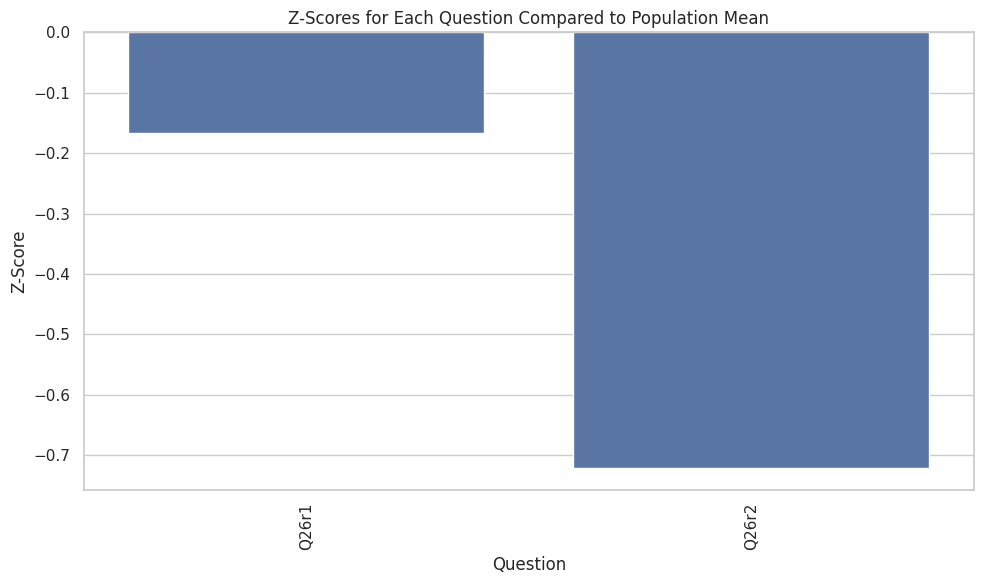

In [ ]:
# Convert the means and standard deviations to a DataFrame for easy plotting
z_scores_df = pd.DataFrame(list(z_scores_dict.items()), columns=['Question', 'Z-Score'])

# Create a Seaborn plot to visualize the Z-scores
plt.figure(figsize=(10, 6))

# Plot a barplot for the Z-scores
sns.barplot(x='Question', y='Z-Score', data=z_scores_df)

# Rotate the x-axis labels to prevent overlapping
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel("Question")
plt.ylabel("Z-Score")
plt.title("Z-Scores for Each Question Compared to Population Mean")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


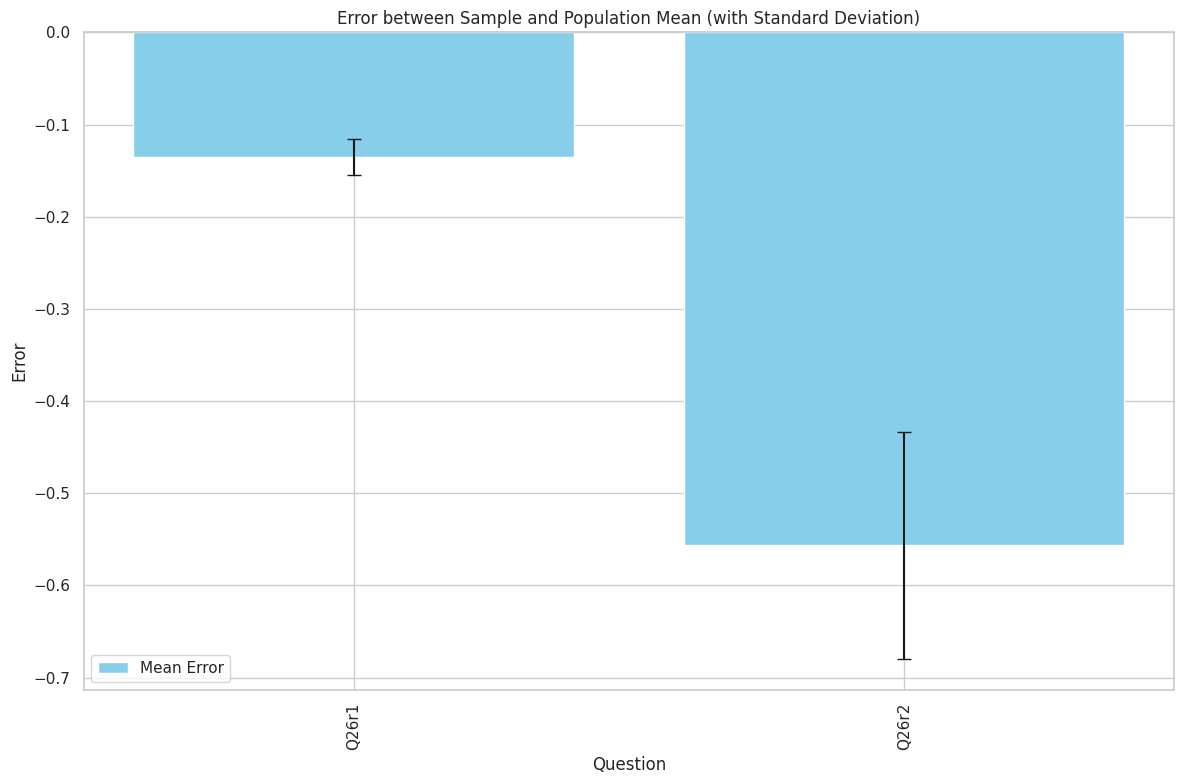

In [ ]:

# Assuming you have the following dictionaries populated: sample_means, population_means, sample_stds, population_stds
# These dictionaries have questions as keys and their respective means and standard deviations as values

# Calculate the errors between sample and population means
mean_errors = {question: sample_means[question] - population_means.get(question, 0) for question in sample_means}

# Calculate the errors between sample and population standard deviations
std_errors = {question: sample_stds[question] - population_stds.get(question, 0) for question in sample_stds}

# Prepare for plotting
questions = list(sample_means.keys())  # List of questions (e.g., Q1, Q2, Q3)
mean_error_values = list(mean_errors.values())  # Mean errors for each question
std_error_values = list(std_errors.values())  # Standard deviation errors for each question

# Create a bar plot for the mean errors
plt.figure(figsize=(12, 8))
x_pos = np.arange(len(questions))

# Plot Mean Error as Bars
plt.bar(x_pos, mean_error_values, color='skyblue', label='Mean Error', yerr=std_error_values, capsize=5)

# Add labels and title
plt.xlabel('Question')
plt.ylabel('Error')
plt.title('Error between Sample and Population Mean (with Standard Deviation)')
plt.xticks(x_pos, questions, rotation=90)  # Rotate x-axis labels for better readability
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


#Additional Sample Statistics


In [ ]:
def calculate_response_trait_stats(full_responses_df):
    full_responses_df["Response"] = pd.to_numeric(full_responses_df["Response"], errors="coerce")

    # Dynamically determine trait columns (assuming the first few columns are Question and Response)
    trait_columns = full_responses_df.columns[3:12]  # Adjust starting index based on actual data

    results = []  # List to collect the results for each trait and question

    # Loop through each trait column to calculate and collect statistics
    for trait in trait_columns:
        # Group data by the trait values and questions
        stats = (
            full_responses_df.groupby(["Question", trait])
            .agg(
                Mean_Response=("Response", "mean"),
                Std_Deviation=("Response", "std")
            )
            .reset_index()
        )

        # Add the stats to the results list
        for _, row in stats.iterrows():
            results.append({
                "Question": row["Question"],
                "Trait": trait,
                "Trait Value": row[trait],
                "Mean Response": round(row["Mean_Response"], 2),
                "Standard Deviation": round(row["Std_Deviation"], 2)
            })

    # Convert the results list to a DataFrame
    stats_df = pd.DataFrame(results)

    return stats_df

# Call the function to get the output as a DataFrame
response_stats_df = calculate_response_trait_stats(full_responses_df)

# Display the result
response_stats_df.head(20)


,Question,Trait,Trait Value,Mean Response,Standard Deviation
0,#question\n attribute triumphs in my lif...,Age,2,2.00,NaN
1,#question\n attribute triumphs in my lif...,Age,3,3.33,0.58
2,#question\n attribute triumphs in my lif...,Age,4,2.00,NaN
3,#question\n I accomplish the goals I set ...,Age,2,2.00,NaN
4,#question\n I accomplish the goals I set ...,Age,3,3.00,1.00
5,#question\n I accomplish the goals I set ...,Age,4,2.00,NaN
6,#question\n attribute triumphs in my lif...,Marital Status,1,3.00,1.00
7,#question\n attribute triumphs in my lif...,Marital Status,3,2.50,0.71
8,#question\n I accomplish the goals I set ...,Marital Status,1,3.00,1.00
9,#question\n I accomplish the goals I set ...,Marital Status,3,2.00,0.00


<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


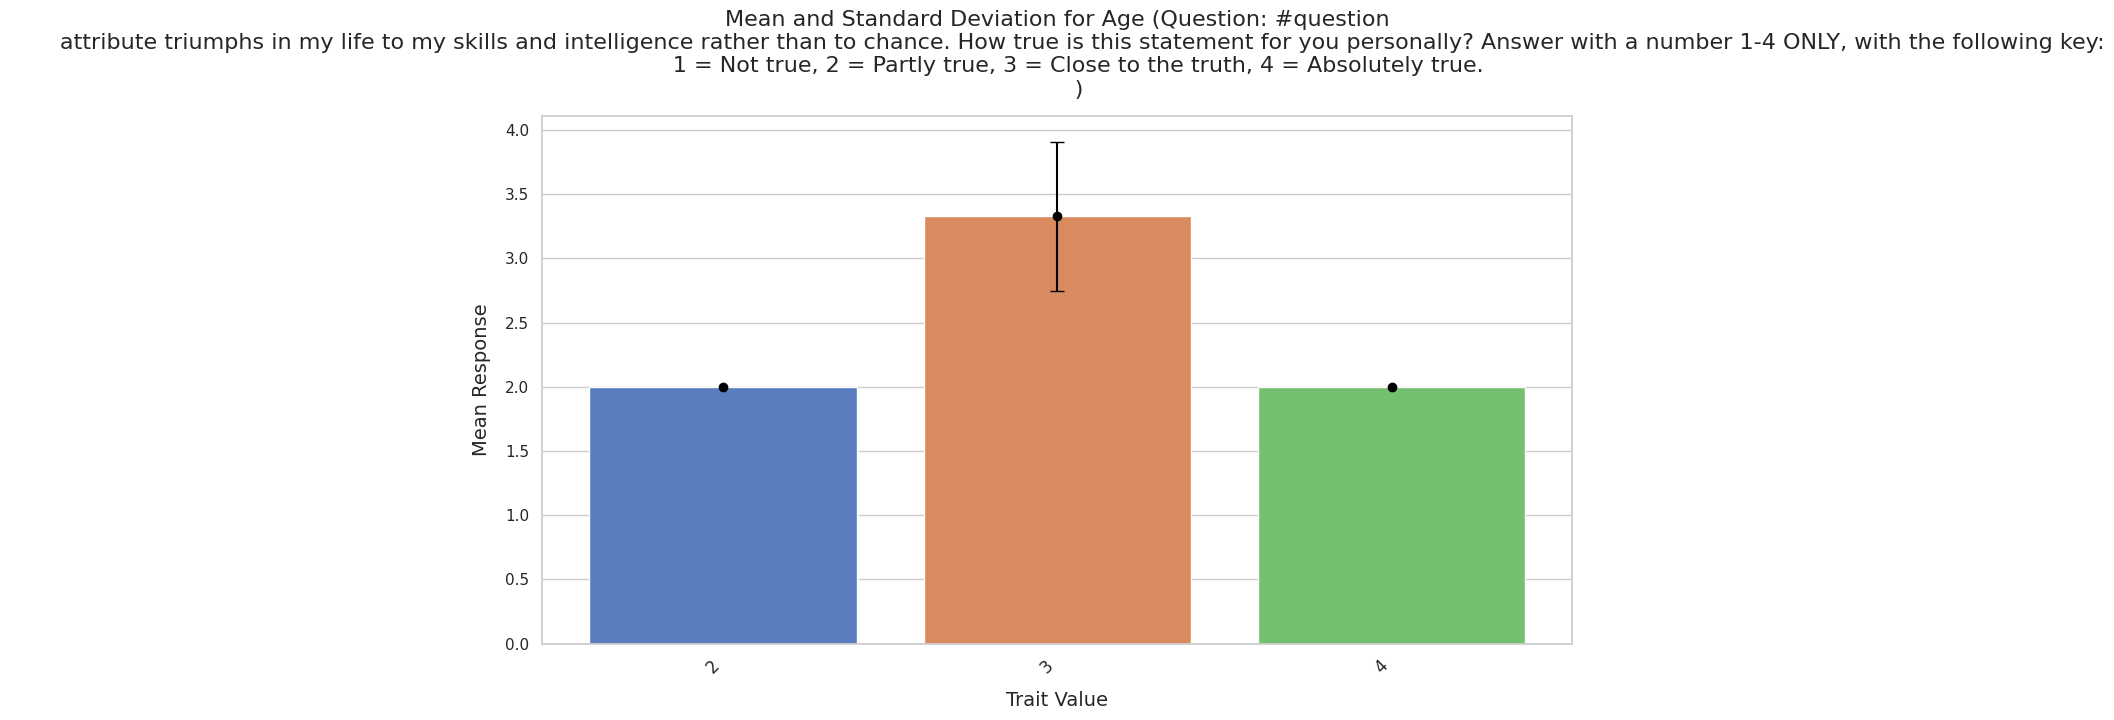

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


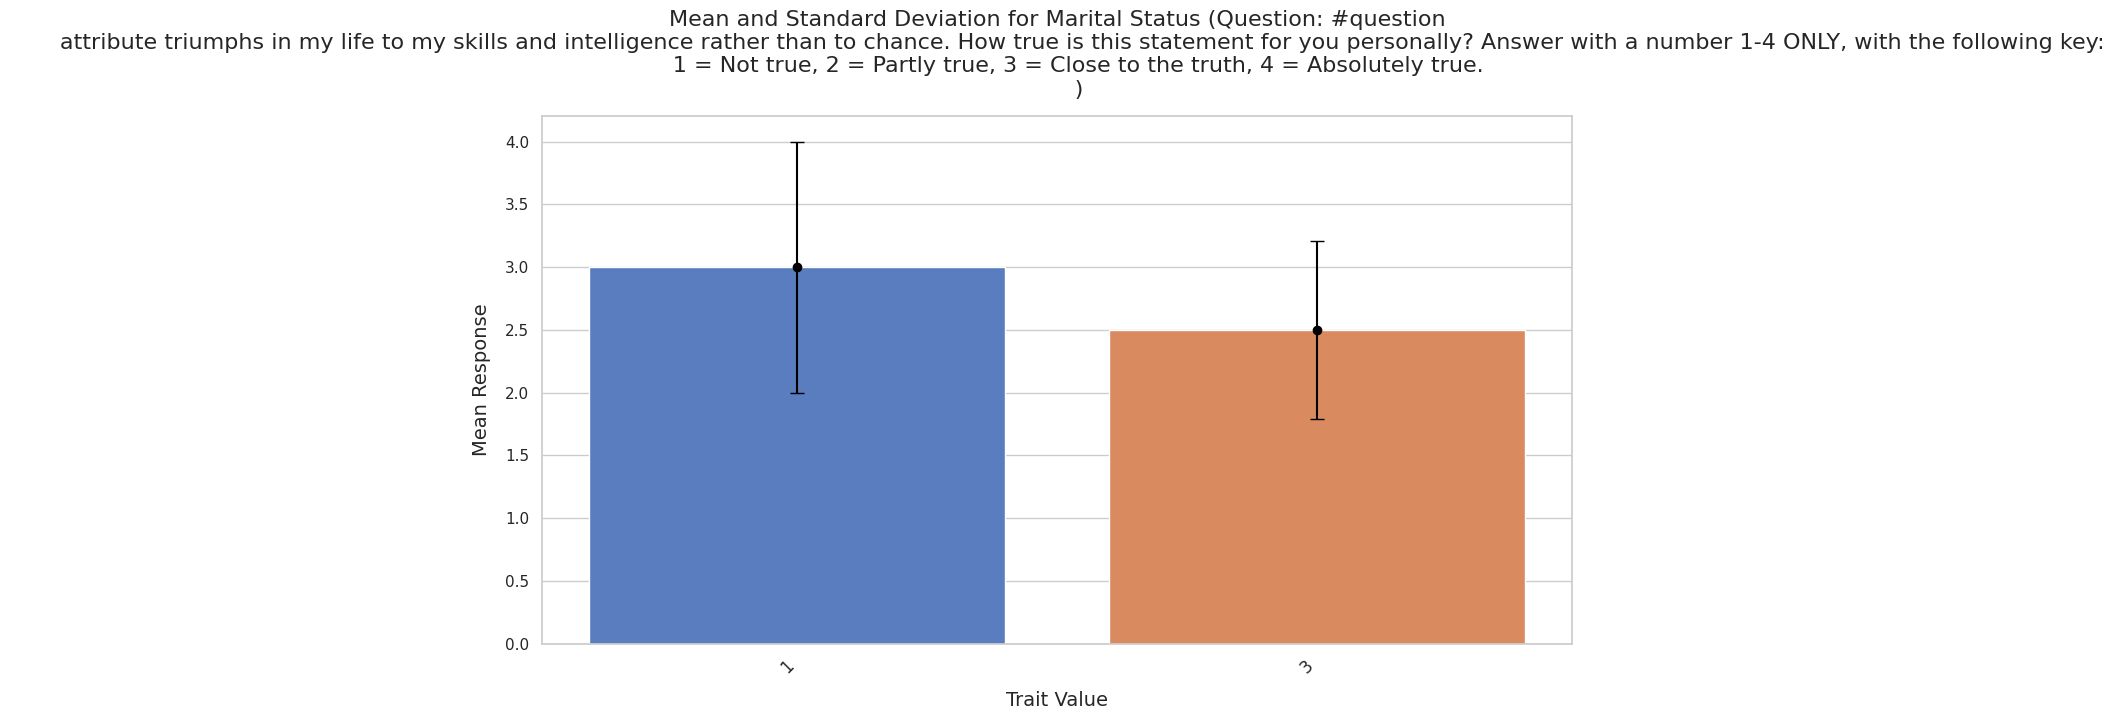

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


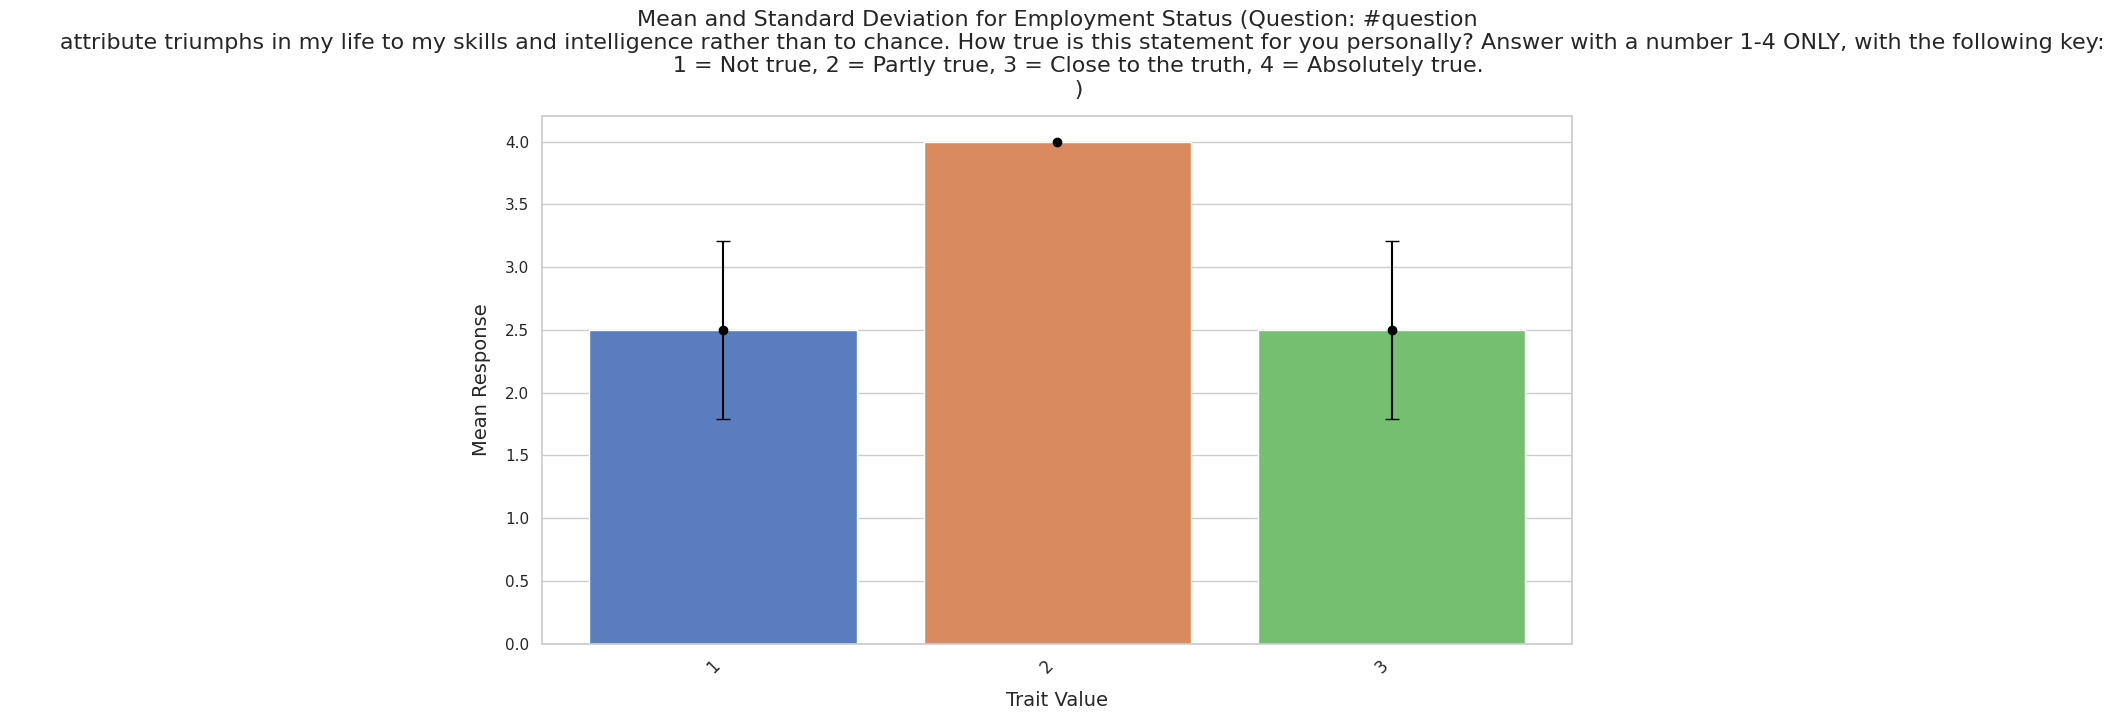

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


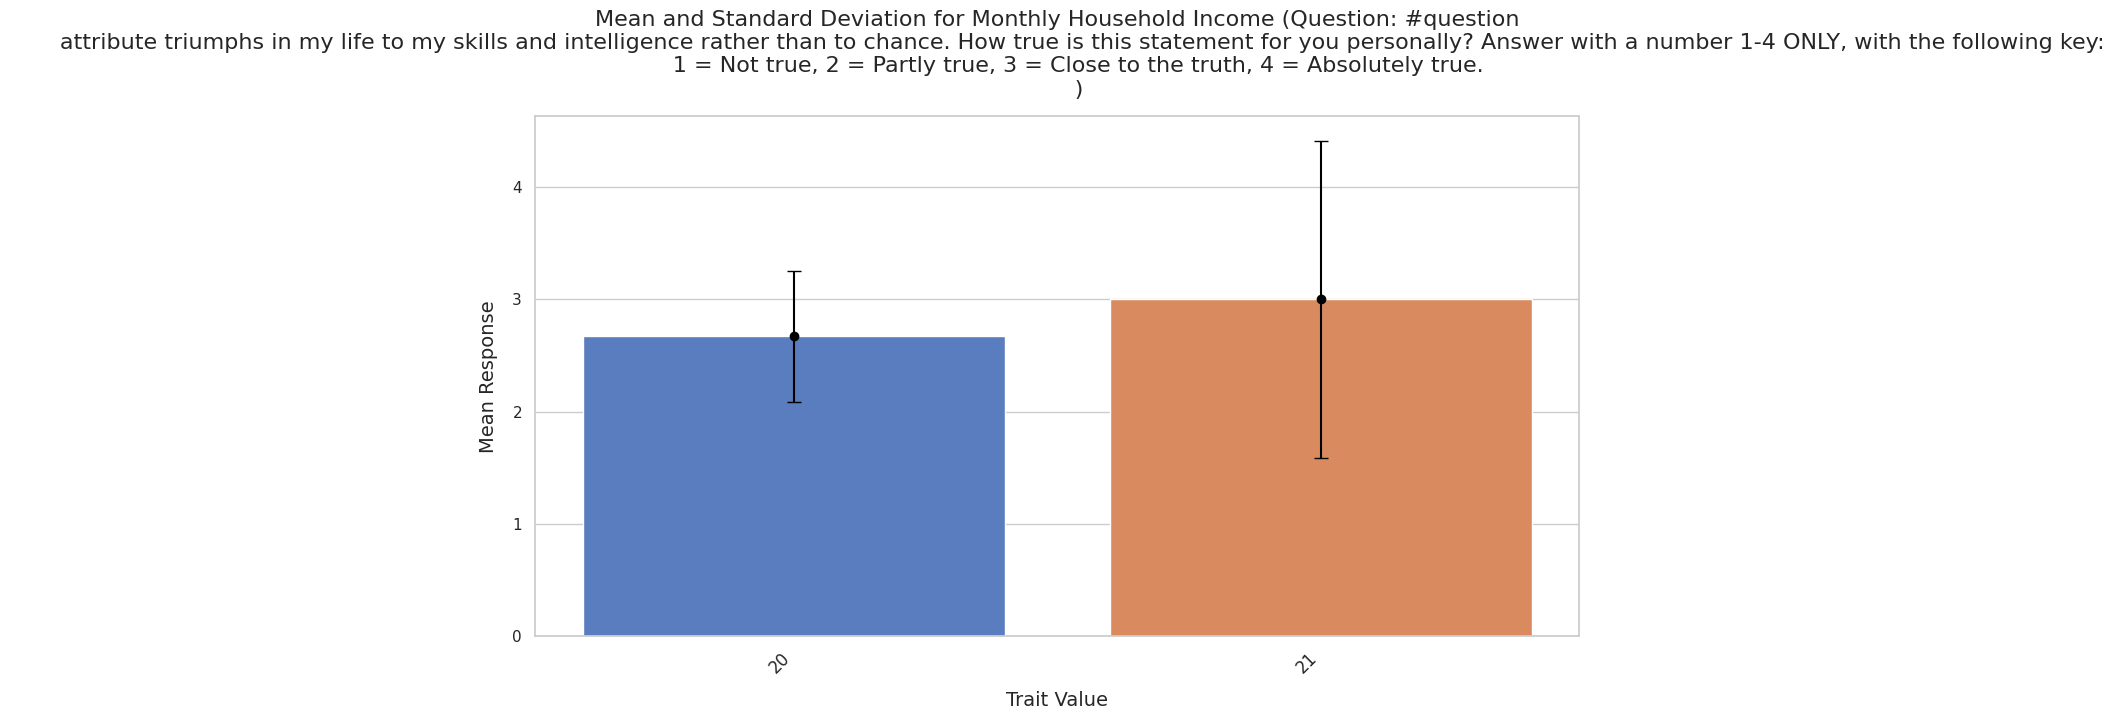

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


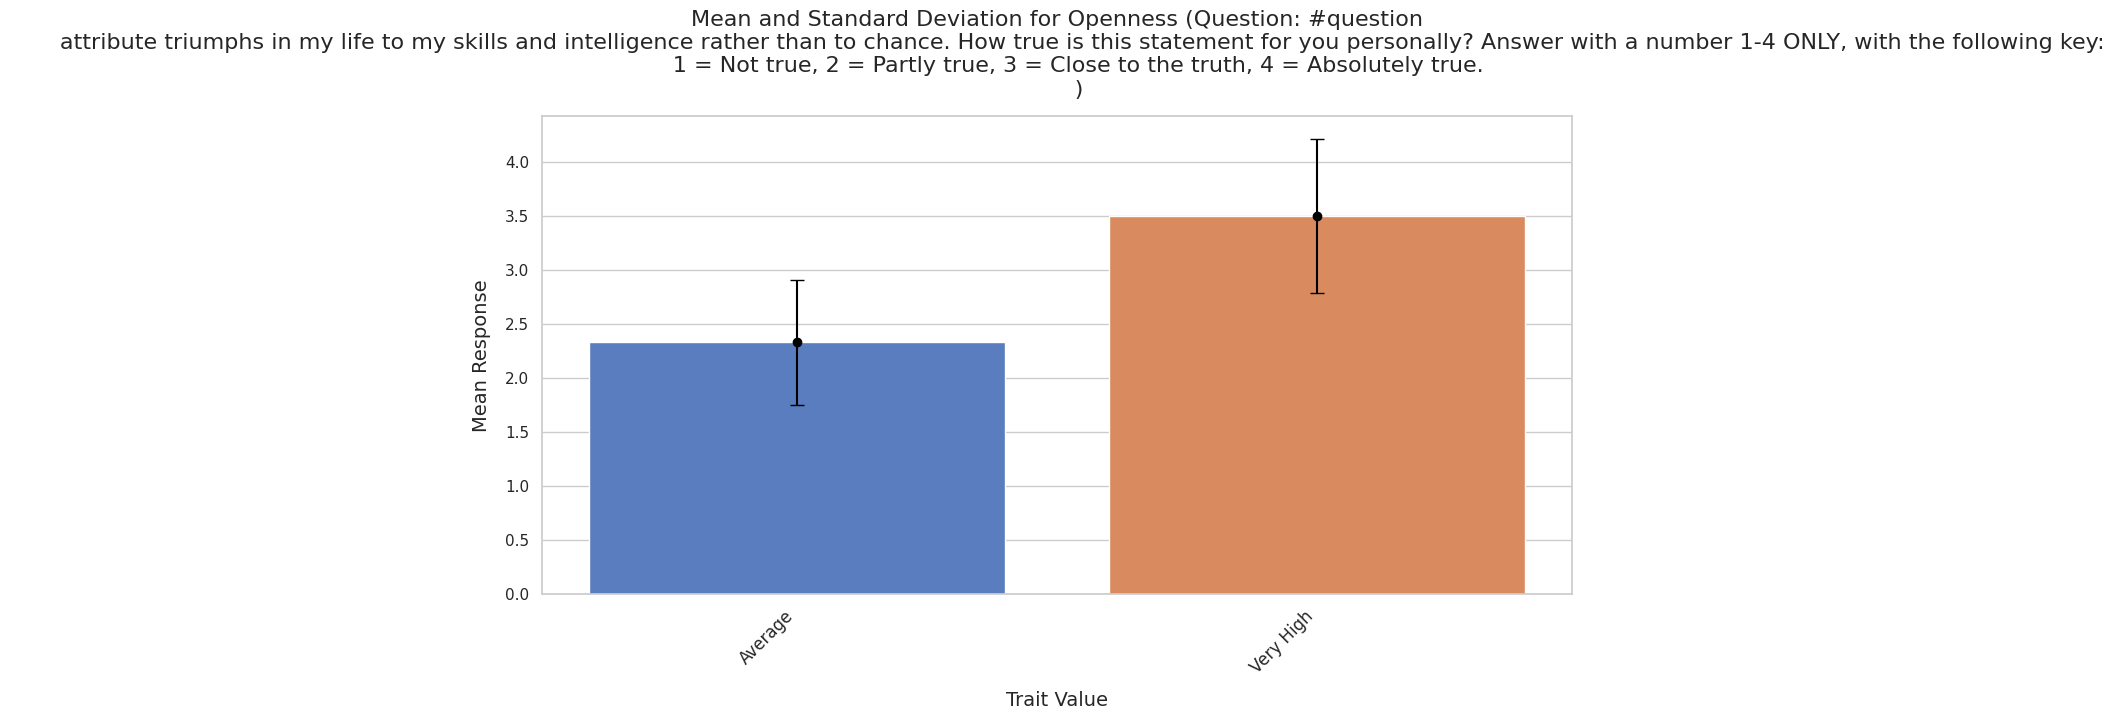

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


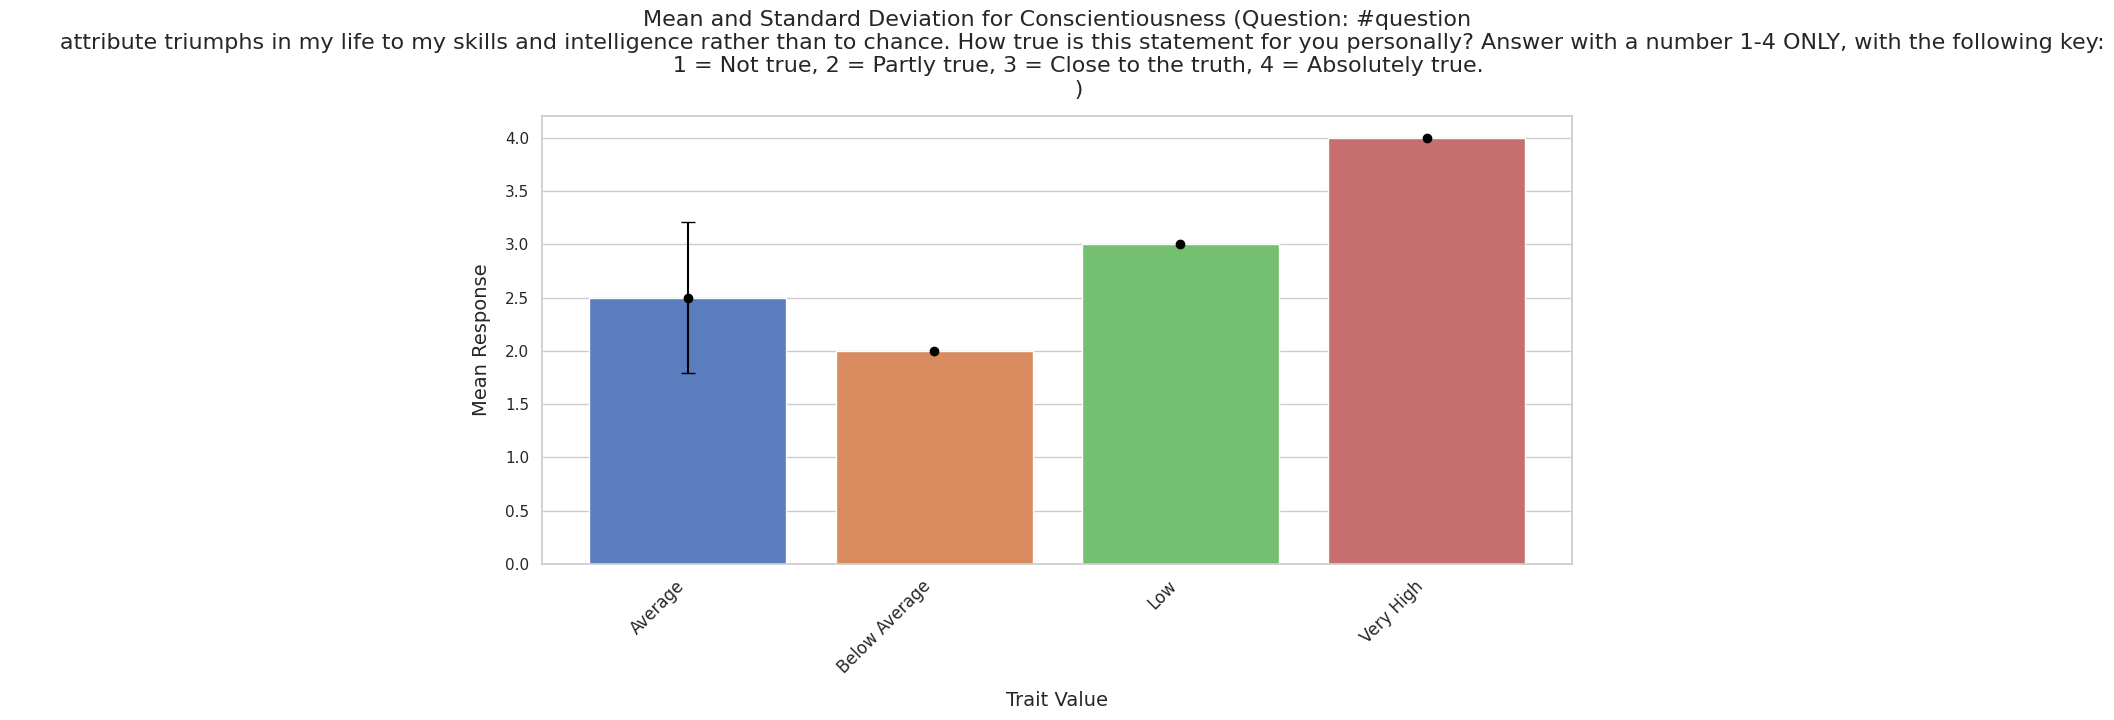

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


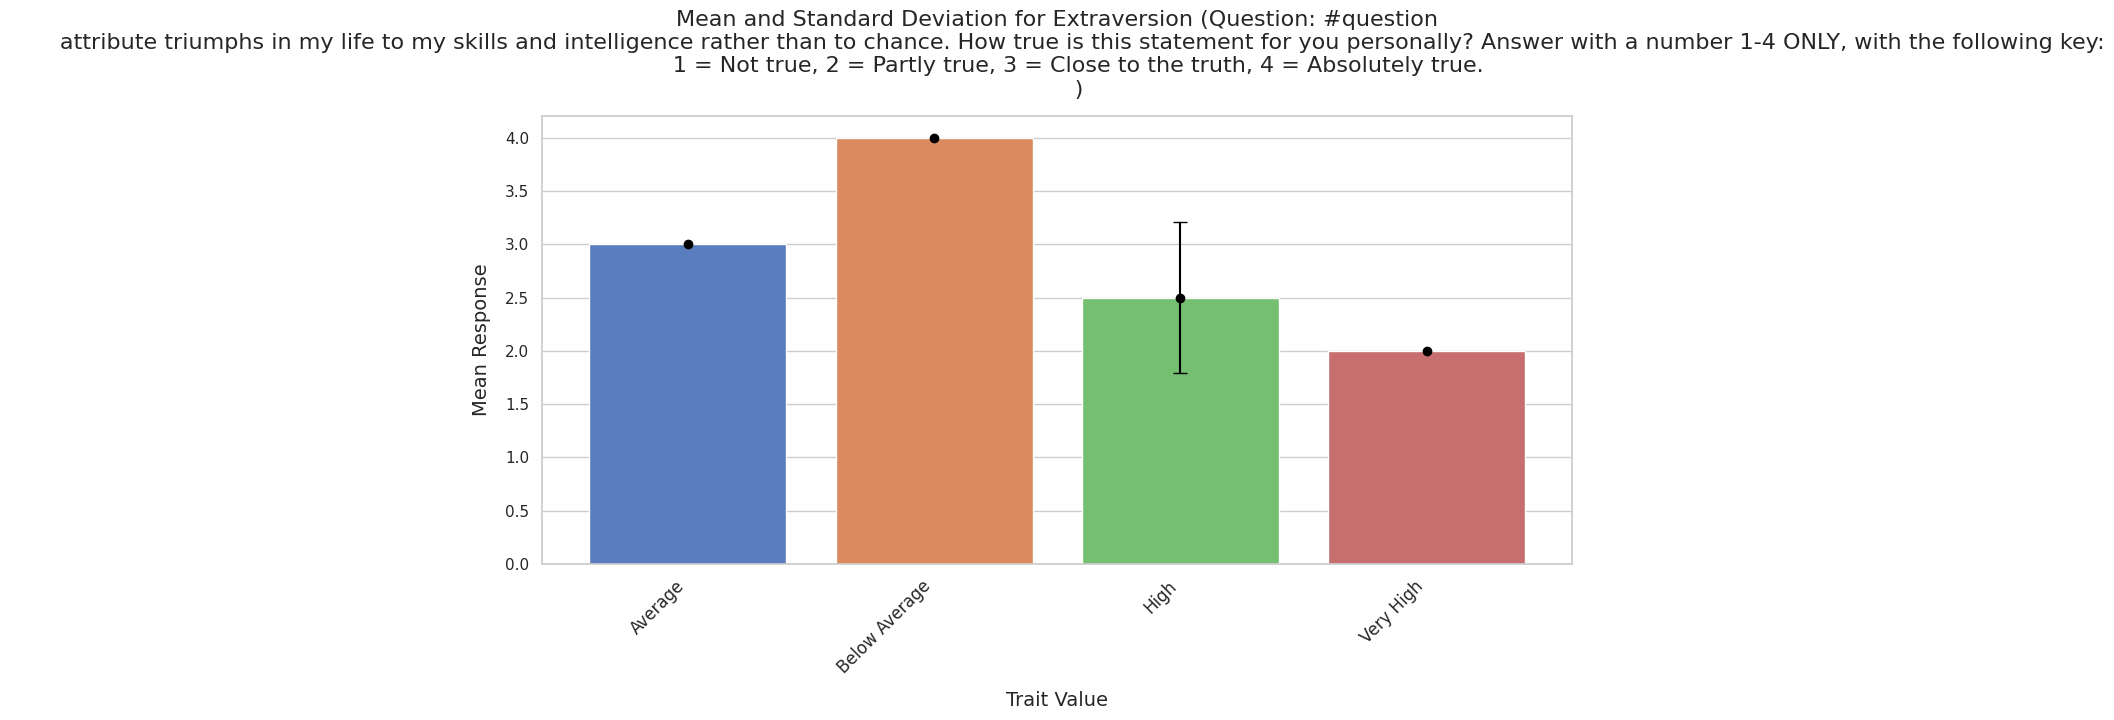

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


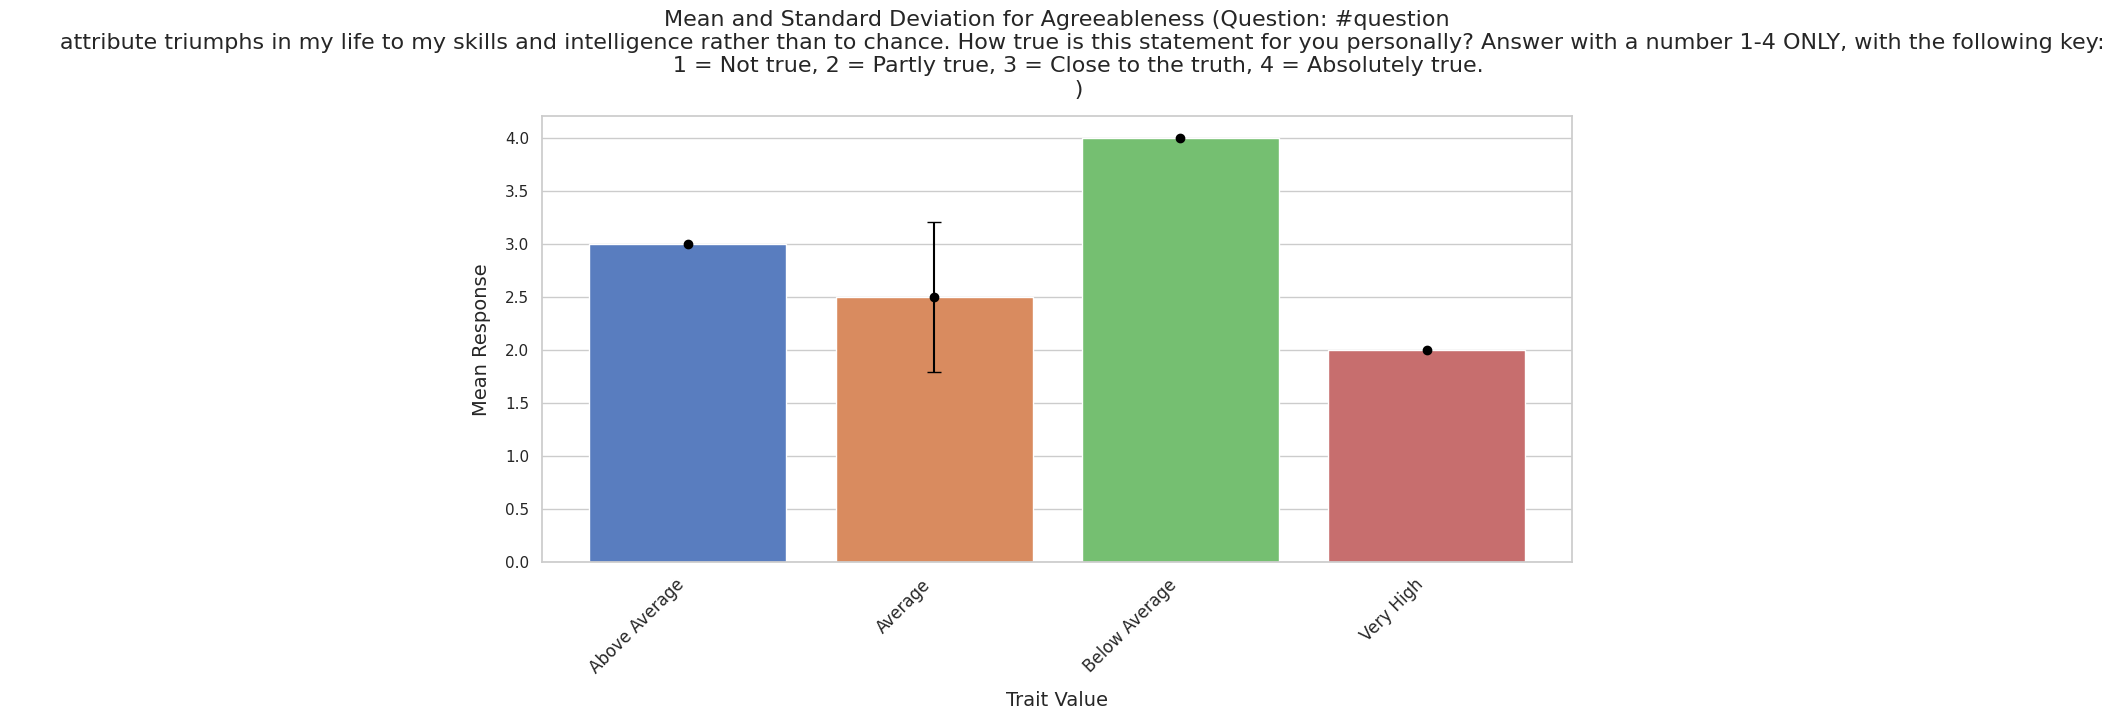

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


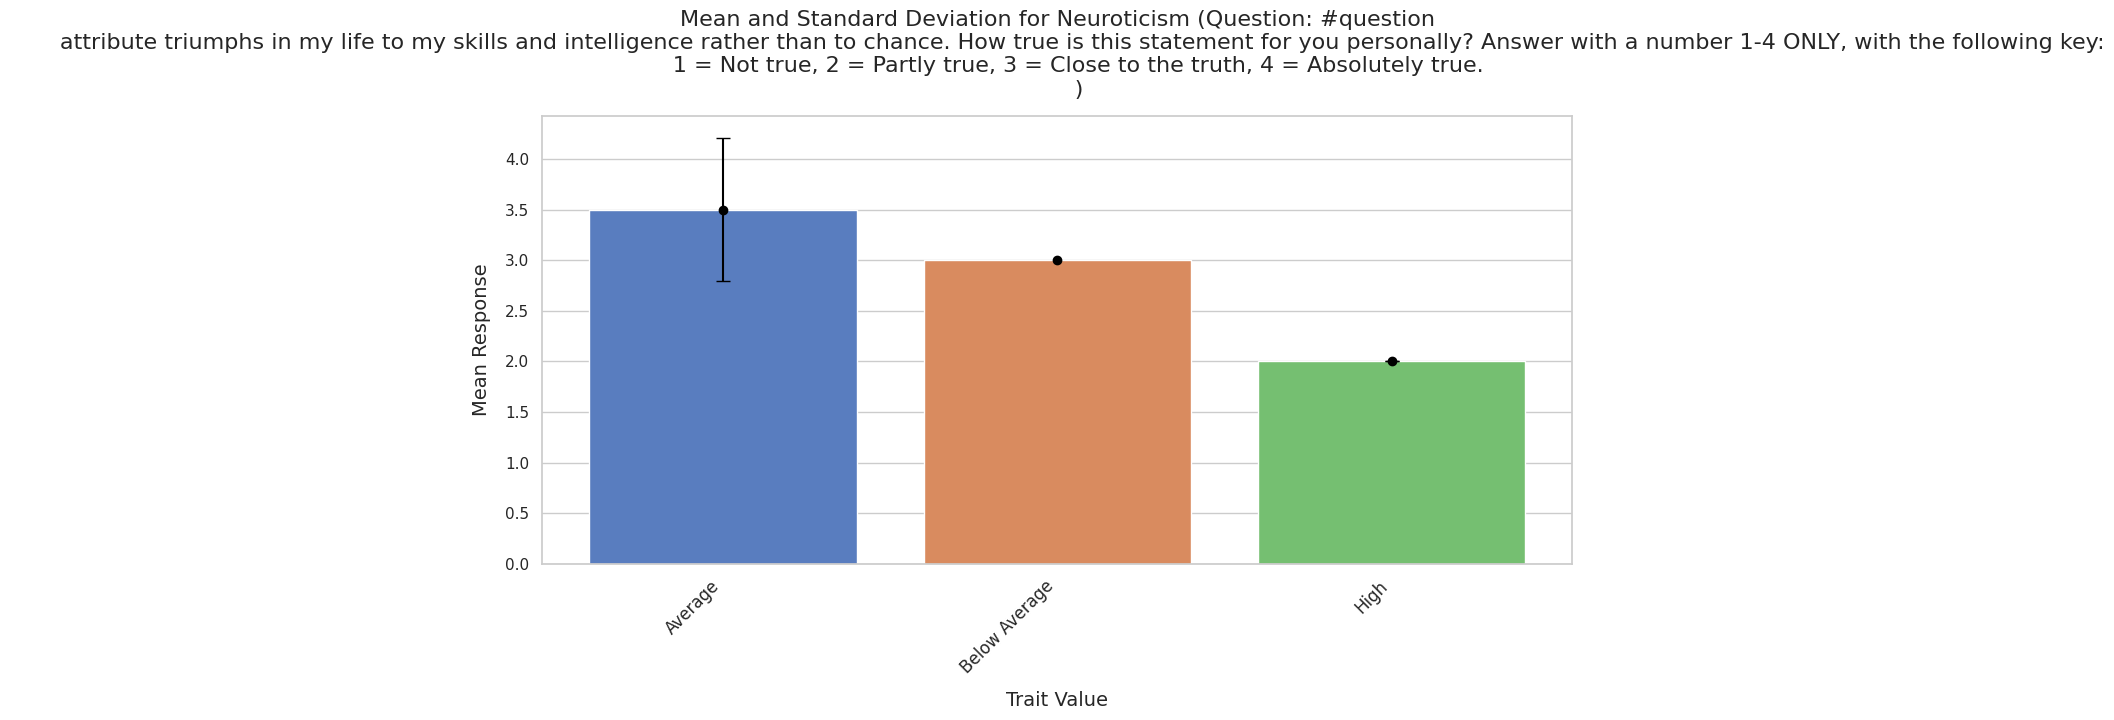

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


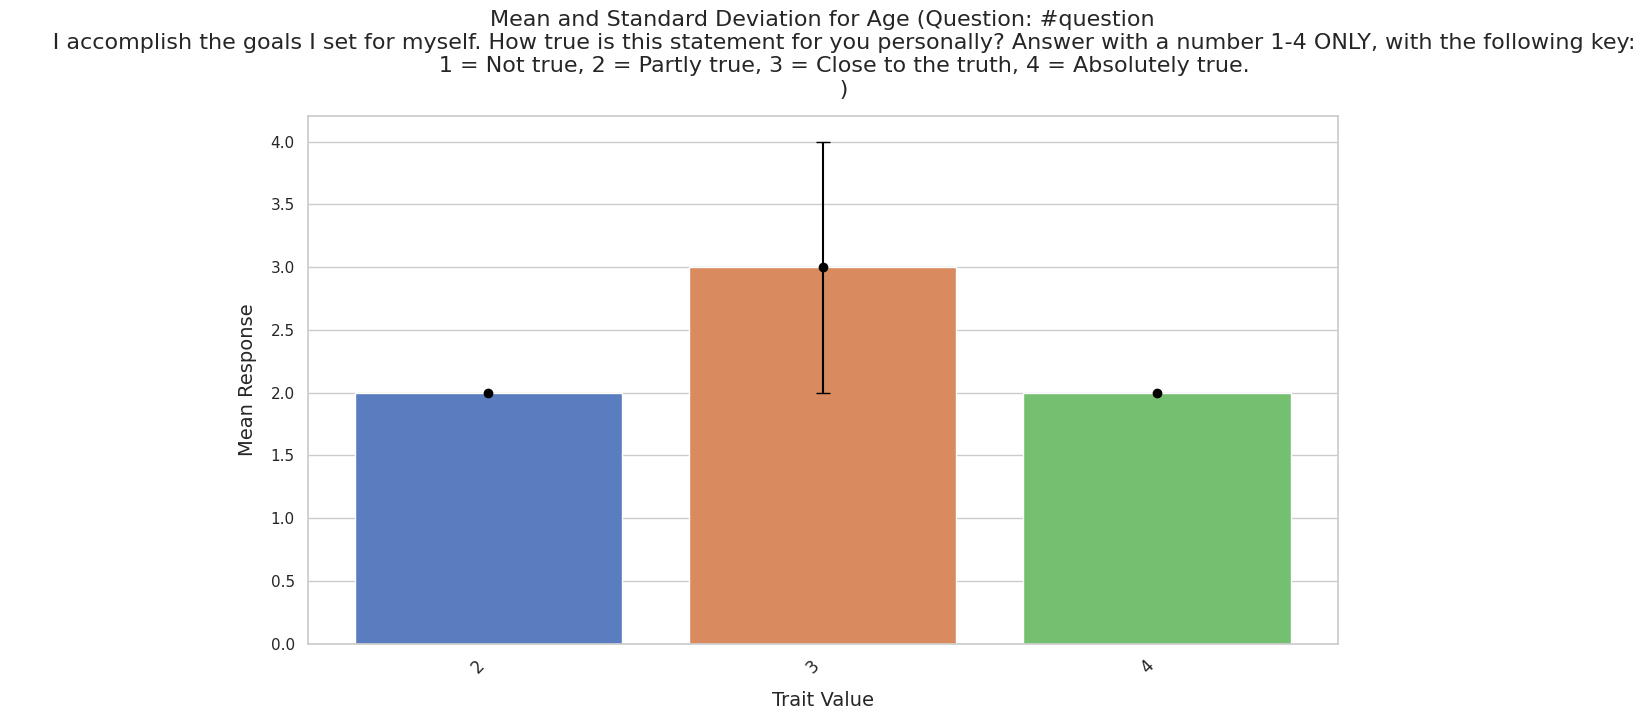

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


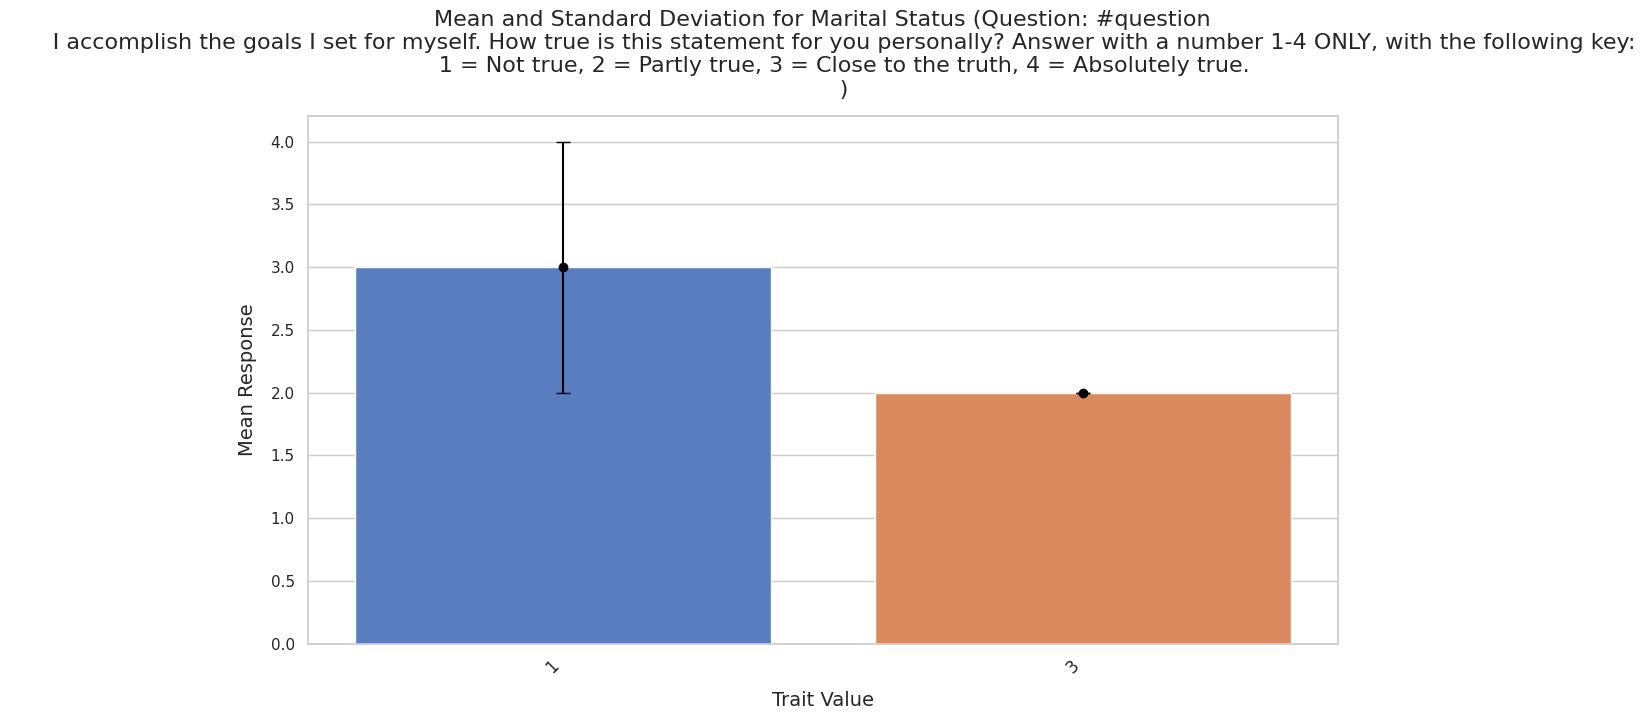

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


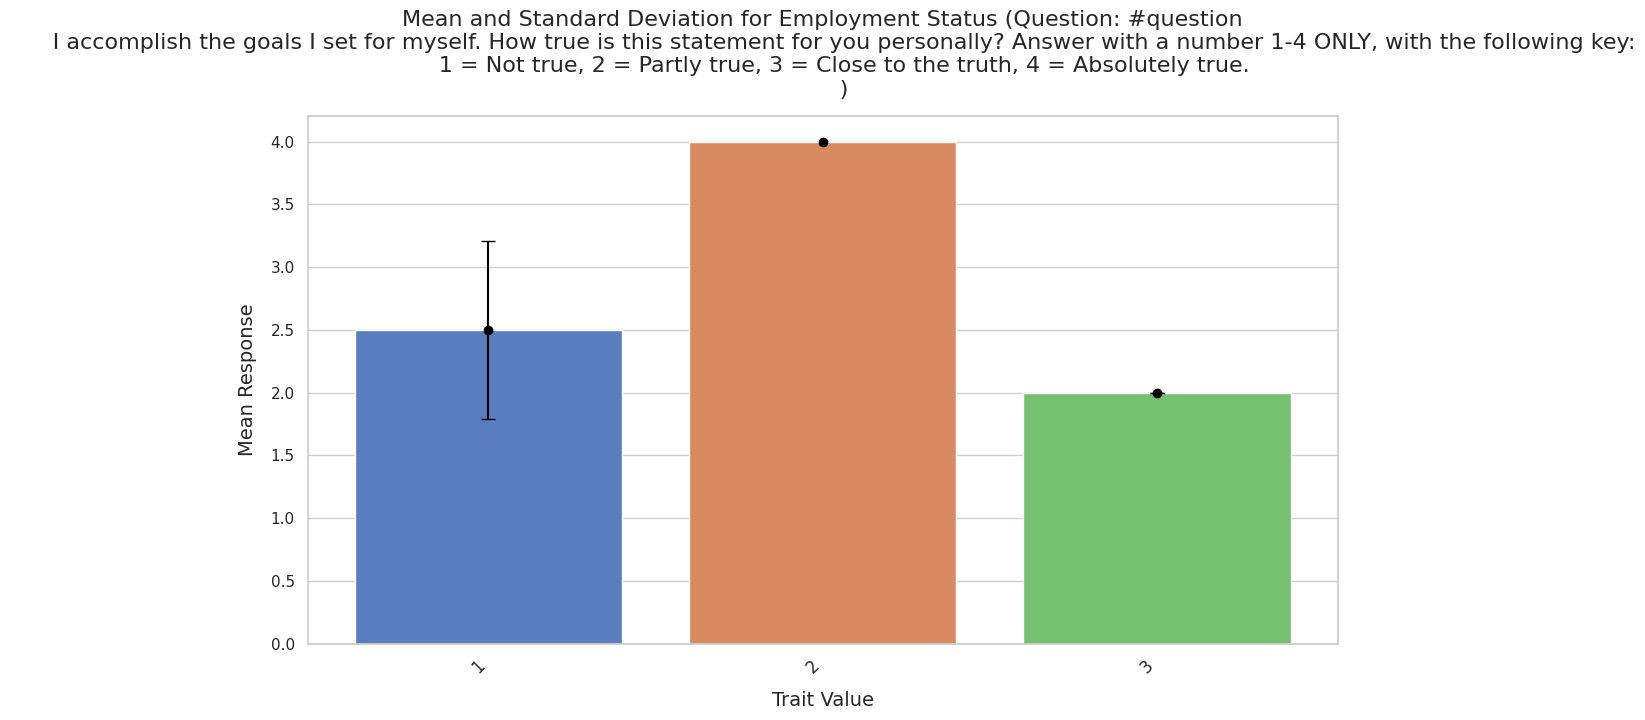

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


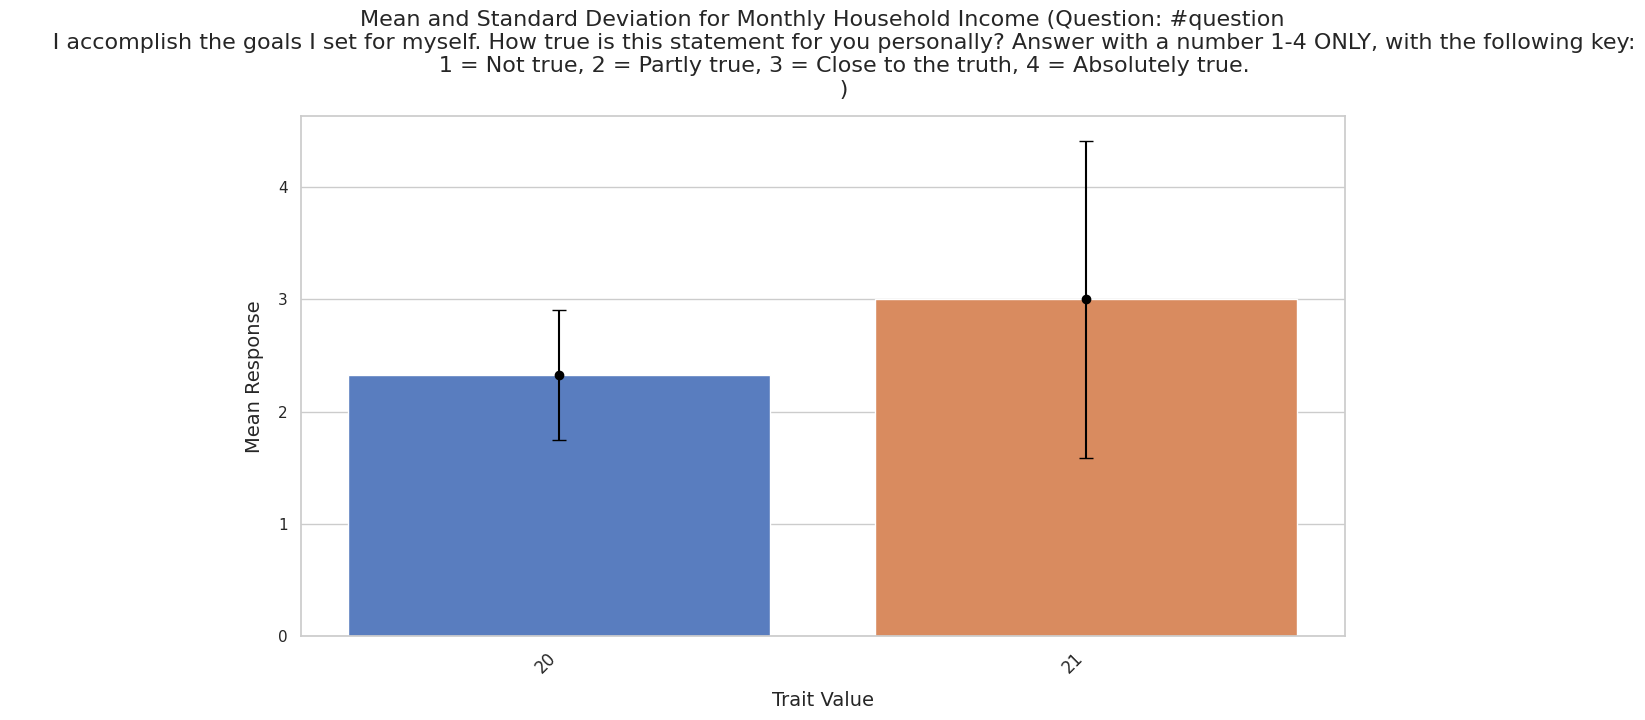

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


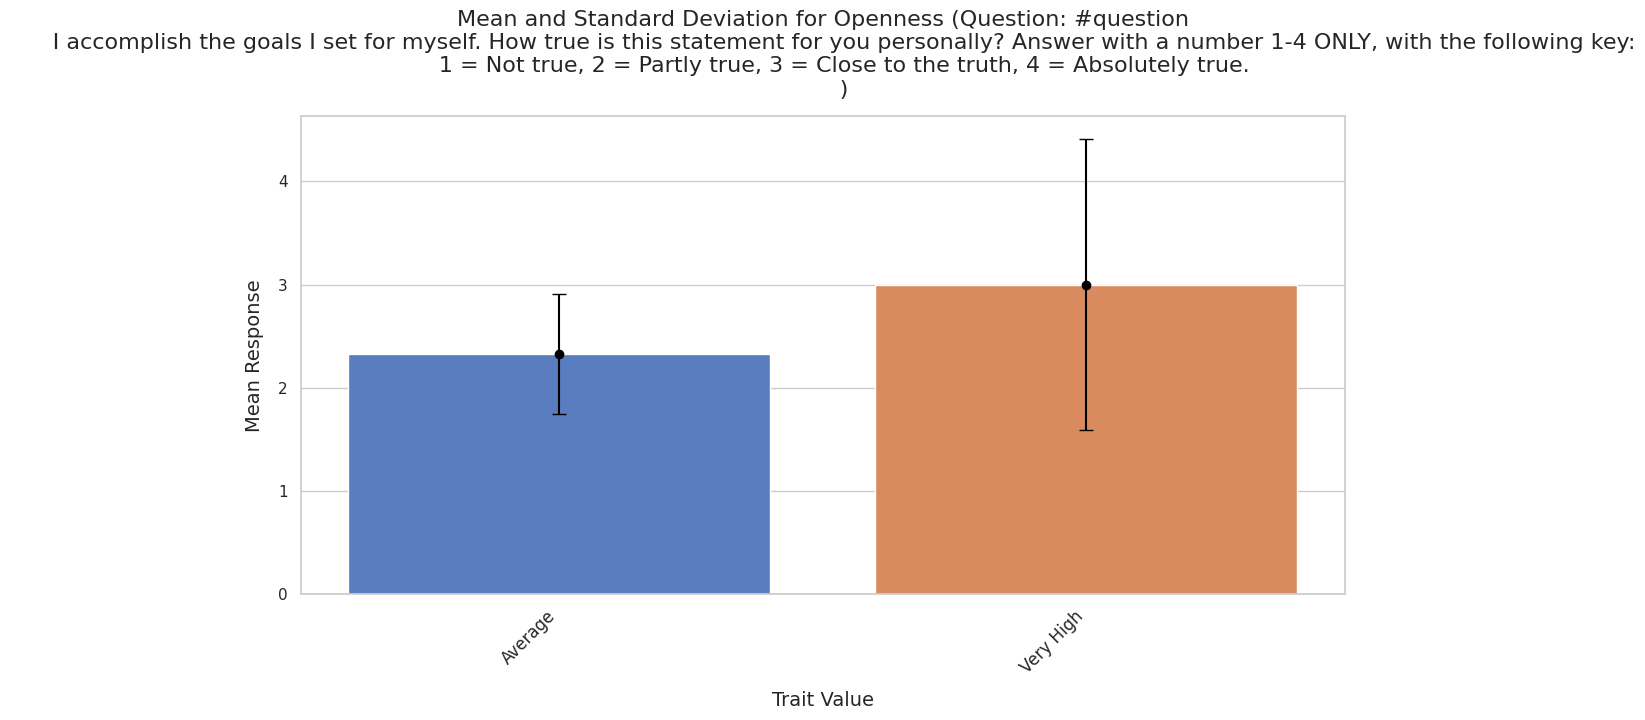

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


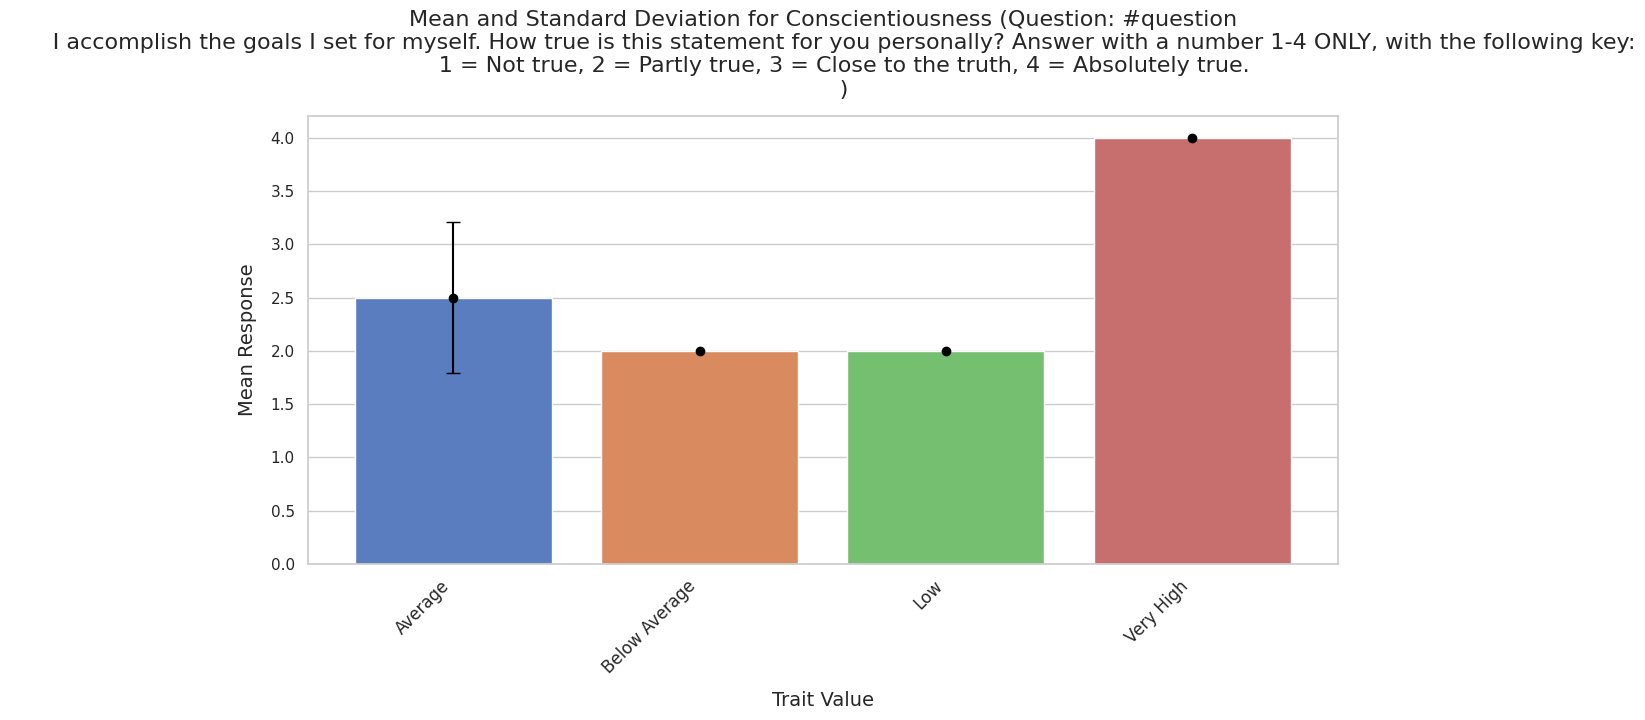

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


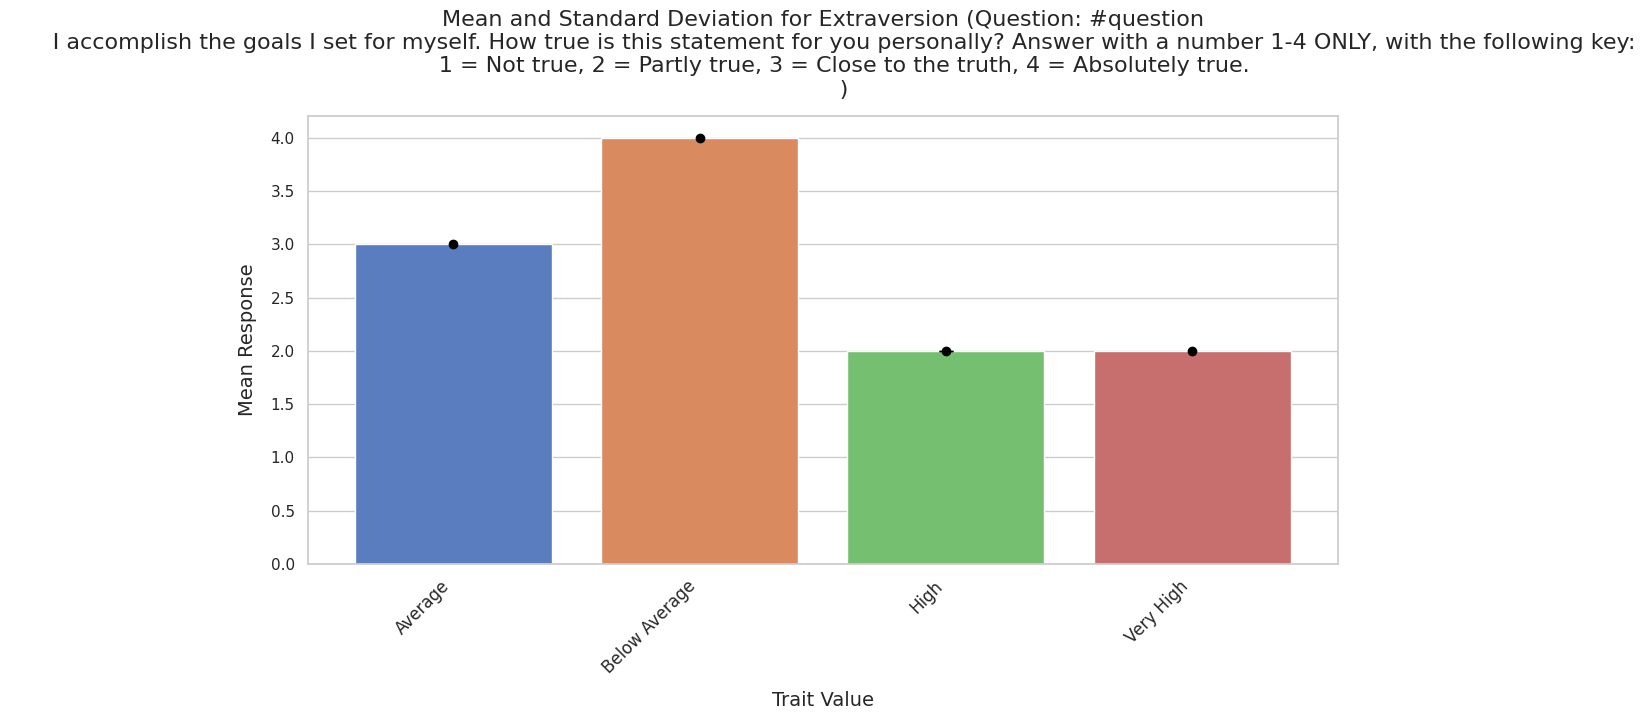

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


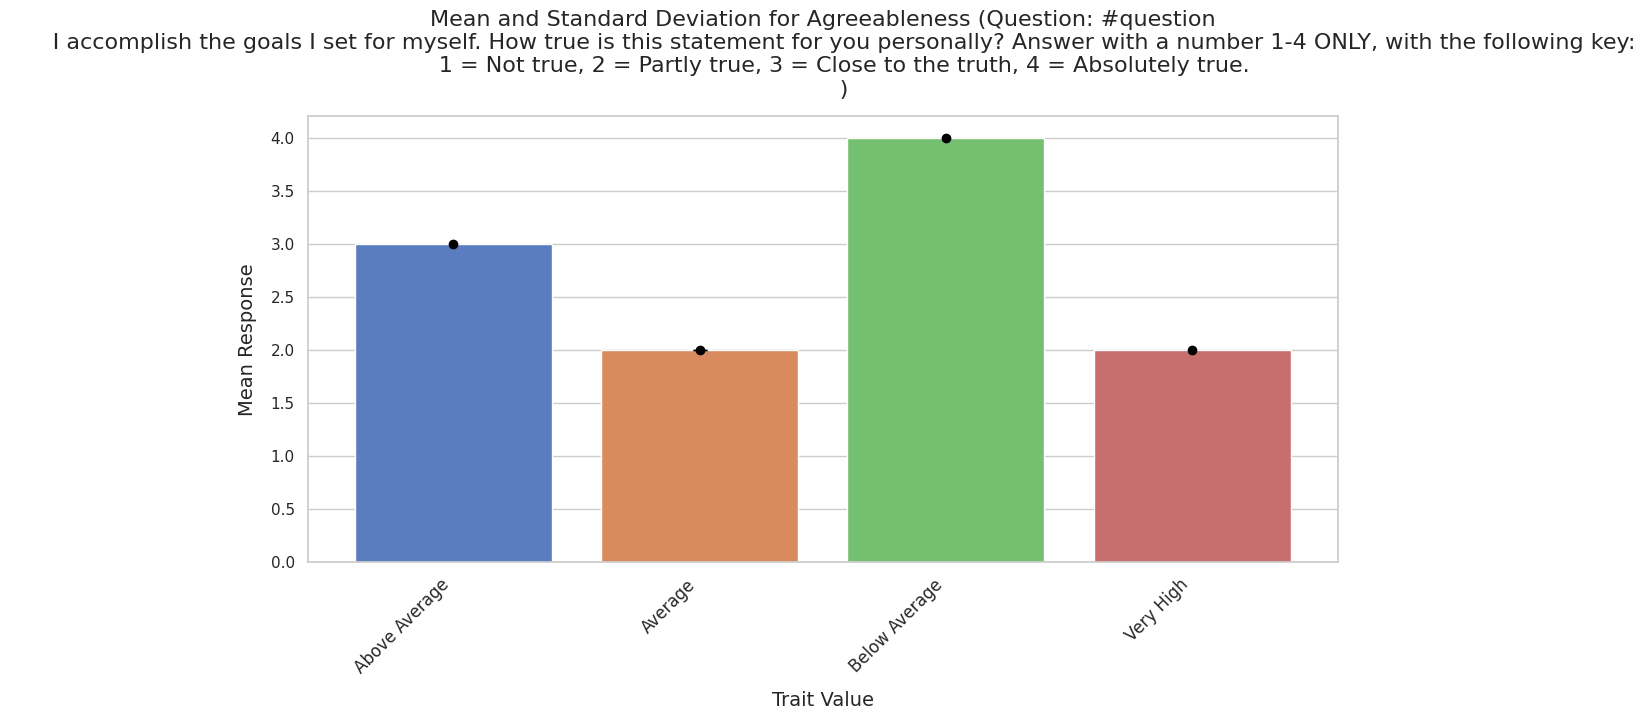

<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-65-dc81a7ea4bfe>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


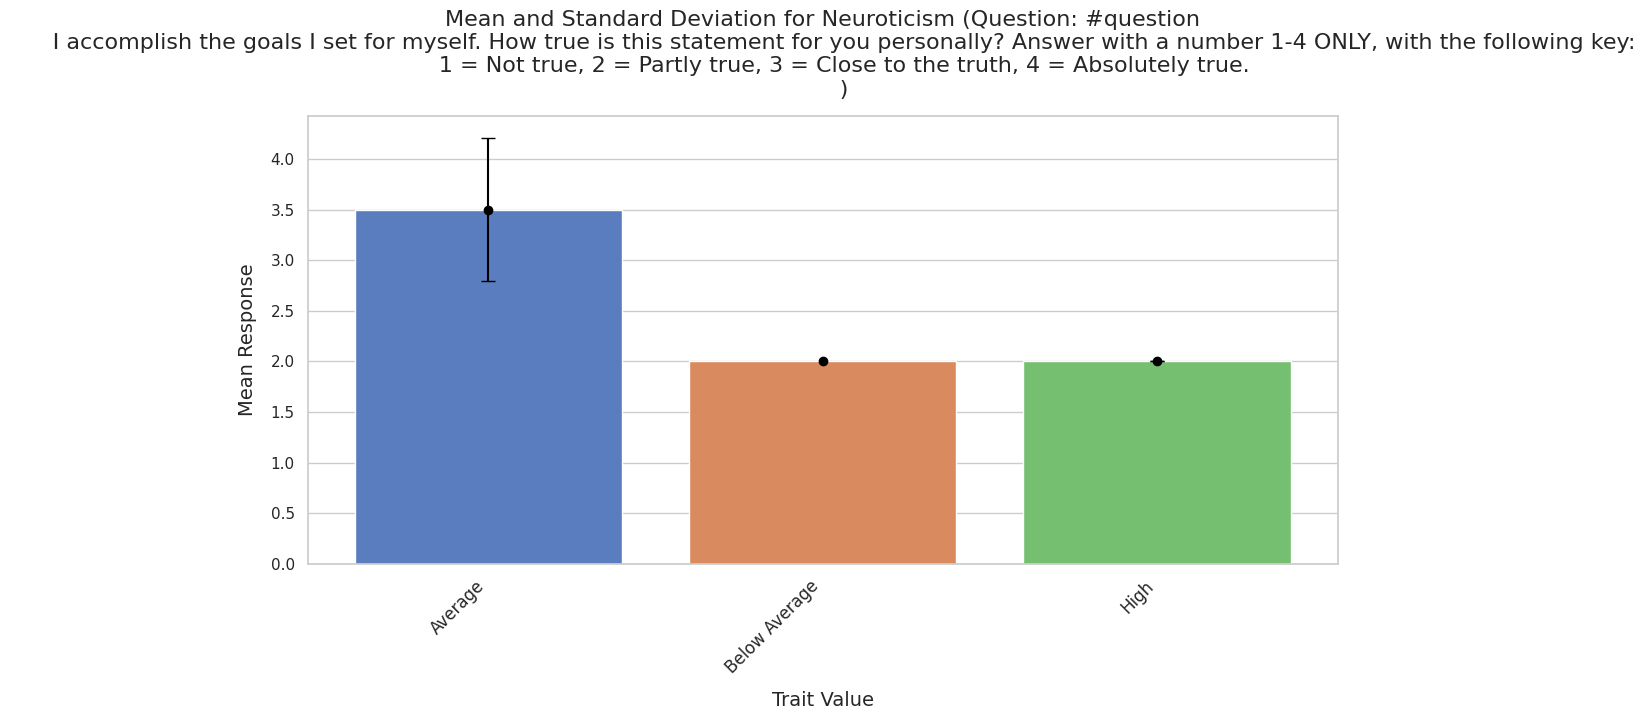

In [ ]:
def plot_response_question_trait_stats(trait_stats_df):
    sns.set(style="whitegrid")  # Set seaborn style

    # Loop through each question
    for question in trait_stats_df['Question'].unique():
        # Filter data for the current question
        question_data = trait_stats_df[trait_stats_df['Question'] == question]

        # Loop through each trait for the question
        for trait in question_data['Trait'].unique():
            # Filter data for the current trait
            trait_data = question_data[question_data['Trait'] == trait]

            # Set up the figure size and axis
            plt.figure(figsize=(12, 8))
            ax = sns.barplot(
                x="Trait Value",
                y="Mean Response",
                data=trait_data,
                palette="muted",
                ci=None
            )

            # Extract bar positions from the plot
            x_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

            # Add error bars for standard deviation
            ax.errorbar(
                x=x_positions,
                y=trait_data["Mean Response"],
                yerr=trait_data["Standard Deviation"],
                fmt='o',
                color='black',
                capsize=5
            )

            # Add titles and labels
            ax.set_title(f"Mean and Standard Deviation for {trait} (Question: {question})", fontsize=16, pad=15)
            ax.set_xlabel("Trait Value", fontsize=14, labelpad=10)
            ax.set_ylabel("Mean Response", fontsize=14, labelpad=10)

            # Rotate x-axis labels for readability
            plt.xticks(rotation=45, fontsize=12, ha="right")

            # Adjust layout and add spacing
            plt.tight_layout(pad=3.0)

            # Show the plot
            plt.show()

# Call the function to create plots
plot_response_question_trait_stats(response_stats_df)
